In [1]:
from EliCoDe_Start import EliCoDe_init
# add path of EliCoDe scripts to python paths
elicode_init = EliCoDe_init("./EliCoDe/src/") #self.path = "./EliCoDe/src/"
elicode_init.start() # sys.path.insert(1, self.path)
# !!!! DO NOT FORGET TO RUN elicode_end() AT THE END OF EXECUTION TO REMOVE PATH

In [2]:
from GED import *
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from utils import levenshtein

C:\Users\Anton\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from spacy.tokens import Doc

In [4]:
from transformers import pipeline

unmasker = pipeline("fill-mask", model="xlm-roberta-large")

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from utils import calc_prf05, df_calc_prf05

In [11]:
GT_df = pd.read_csv('Ground_true.csv') # dataset of manualy checked for errors (contains error free text. Does not contain GT for error detection)
GT_df = GT_df.drop(['Unnamed: 3'], axis=1)
GT_df = GT_df[GT_df['Checked'] == True]

----------

GED: create list of tokens and errors with spacy and EliCoDe

In [84]:
text = GT_df.iloc[31]['OCR_Text']
ged, text_words = elicode_pred(text, tokenizer_type='spacy')

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2581' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    ap

In [85]:
print(len(ged), len(text_words))

4028 4028


sequerncial error fix:

In [89]:
doc = nlp(text)

In [6]:
def mask(text, reference, pipeline, top_k = 20, special_char = None):
    first_token = []
    second_token = []
    umask = pipeline(text, top_k)
    for um in umask[0]:
        dist = levenshtein(um['token_str'], reference)
        first_token.append((um['token_str'], dist))
    for um in umask[1]:
        dist = levenshtein(um['token_str'], reference)
        second_token.append((um['token_str'], dist))
    
    first_token = sorted(first_token, key=lambda tup: tup[1])
    result=[]
    
    if special_char is not None:
        for first in first_token:
            for second in second_token:
                fs = first[0]+special_char+second[0]
                dist = levenshtein(fs, reference)
                result.append((fs, dist))
    else:
        for first in first_token:
            dist = levenshtein(first[0], reference)
            result.append((first[0], dist))
            for second in second_token:
                fs = first[0]+second[0]
                dist = levenshtein(fs, reference)
                result.append((fs, dist))
    return sorted(result, key=lambda tup: tup[1])[0]

In [7]:
def set_spaces(tokens):
    spaces = [True] * len(tokens)    
    for i, token in enumerate(tokens):
        if i != 0:
            if token in [',','.',':','!','?']:
                spaces[i-1] = False
        try:
            if len(token) > 0:
                if token[-1] == "'" or token[-1] == "’":
                    spaces[i] = False
        except:
            print("Exception ",token, "Len ", len(token))
            raise IndexError()
    return spaces

def tokens_to_text(tokens):
    spaces = set_spaces(tokens)
    new_text = Doc(nlp.vocab, words=tokens, spaces=spaces)
    return new_text.text

In [8]:
def remove_empty_from_lists(list_to_search, additional_list):
    if len(list_to_search) != len(additional_list):
        raise Error("different length of lists")
        
    to_delete = []
    list1 = list_to_search.copy()
    list2 = additional_list.copy()
    for i, l in enumerate(list_to_search):
        if len(l) == 0:
            to_delete.append(i)
    for i in reversed(to_delete):
        del list1[i]
        del list2[i]
    return list1, list2
    

def GEC_elicode(text, tokenizer_type='regex', alpha = 0.5, beta = 0.9, delta = 4):
    # Split text in sentences and detect errors in text by using EliCoDe
    # Split is necessary for big texts!
    # tokenizer_type values accectable: 'regex', 'spacy'
    fixed_text = []
    if tokenizer_type != 'regex' and tokenizer_type != 'spacy':
        raise ValueError("Wrong tokenizer_type")
    sentences = split_in_sentence(text)
    results = []
    to_text_words = []
    i = 0
    j = 0
    sent = ""
    for s in sentences:
        if j < 4:
            if j == 0:
                sent = s
            else:
                sent = sent + "\n\n" + s
            j += 1
        else:
            j = 0
            sent = sent + "\n\n" + s
            words, res = elicode_pre_in(sent, tokenizer_type)
            results.append(res)
            to_text_words.append(words)
            
            new_text = fix_errors(sent.replace("\n\n", " "), res, words)
            
            fixed_text = fixed_text + new_text
            clear_output(wait=True)
            #print(new_text)
            # print(words)
            # print("=================")
            sent = ""
        i += 1

    if j > 0:
        words, res = elicode_pre_in(sent, tokenizer_type)
        results.append(res)
        to_text_words.append(words)
    
        new_text = fix_errors(sent.replace("\n\n", " "), res, words, alpha=alpha, betta = beta, delta = delta)
        fixed_text = fixed_text + new_text

    result = []
    for lis in results:
        result = result + lis
    text_words = []
    for words in to_text_words:
        text_words = text_words + words
    return result, text_words, fixed_text

In [27]:
def fix_errors(sent, ged, text_words, alpha = 0.5):
    print("Fix: ", sent)
    checked_tokens = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            checked_tokens.append(new_text_words[index]) # add word to correct sequence
            continue # pass to the next token in ged

        print("Error: ", new_text_words[index])

        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[index] = '<mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], new_text_words[index])
            first_token.append((um['token_str'], dist))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                dist = levenshtein(first[0], new_text_words[index])
                result.append((first[0], dist))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        
        

        if levenshtein(candidate[0], new_text_words[index]) <= len(new_text_words[index])*alpha or len(new_text_words[index]) < 4:
            if candidate[0] == "":
                checked_tokens.append(" ")
            else:
                checked_tokens.append(candidate[0])
        else:
            checked_tokens.append(new_text_words[index])

    return checked_tokens

In [28]:
list1 = ["hello", "world", "", "a", "b", ""]
list2 = [True, False, True, True, False, False]
n_list1, n_list2 = remove_empty_from_lists(list1, list2)
print(n_list1, n_list2)

['hello', 'world', 'a', 'b'] [True, False, True, False]


In [29]:
text = GT_df.iloc[31]['OCR_Text']
ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy')

['Considerato', 'poi', 'che', 'il', 'prezzo', 'medio', 'del', 'tabacco', 'in', 'foglie', 'è', 'di', 'lire', '55', 'mila', 'al', 'quintale', ',', 'e', 'ammettendo', 'che', 'dai', '18', 'milioni', 'di', 'dollari', '2', 'milioni', 'vengono', 'destinati', 'al', 'tabacco', ',', 'ne', 'consegue', 'che', 'verranno', 'introdotti', 'in', 'Italia', 'circa', '24', 'mila', 'quintali', '»', '.', 'Questo', 'non', 'lo', 'afferma', ',', 'onorevole', 'ministro', ',', 'l’', 'azienda', 'delle', '(', '(', 'botteghe', 'oscure', '»', ',', 'come', 'stupidamente', 'si', 'dice', 'molte', 'volte', 'quando', 'parlano', 'uomini', 'di', 'questo', 'settore', 'della', 'Camera', '.', 'Il', 'bollettino', 'è', 'edito', 'dalla', '(', '(', 'Confida', ')', ')', '.', 'Gli', 'agrari', 'sono', 'allarmati', 'perché', 'sanno', 'della', 'crisi', 'nel', 'campo', 'della', 'canapa', 'e', 'vedono', 'che', 'l’', 'America', 'ci', 'manda', ',', 'sotto', 'forma', 'di', 'aiuti', ',', 'cotone', ';', 'sanno', 'della', 'crisi', 'dell’', 'o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2581' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    ap

Fix:  E intanto bisogna prendersi questi aiuti americani ! 


In [109]:
alpha = 0.5
sentences = split_in_sentence(text)
gen_text = []
sent = ""
seen = 0
j = 0
for s in sentences:
    if j < 4:
        if j == 0:
            sent = s
        else:
            sent = sent + " " + s
        j += 1
    else:
        j = 0
        sent = sent + " " + s
        
        checked_tokens, length = fix_errors(sent, seen, ged, text_words)
        seen += length
        gen_text = gen_text + checked_tokens
        new_text = tokens_to_text(checked_tokens)
        print("---------------")
        print(new_text)
        
if j > 0:
    checked_tokens, length = fix_errors(sent, seen, ged, text_words)
    seen += length
    gen_text = gen_text + checked_tokens
    new_text = tokens_to_text(checked_tokens)
    print("---------------")
    print(new_text)

Fix:  CALASSO.  L’onorevole Vanoni affermò che avrebbe fatto condurre l’inchiesta e che I’« Inea 1) avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura.  Non sapevo che è s ta ta pubblicata la relazione generale.  Lo apprendo adesso da lei, m a io ho avuto occasione di leggere, dicevo testè, quanto hanno scritto il Prorii, dell’universita di Perugia, e il Rossi Doria sulla tabacchicoltura dell’Italia centrale e meridionale e sui problemi connessi.  Non dimentichi, onorevole ministro, che questi due professori, insieme con l’altro incaricato di dirigere l’inchiesta per il nord Italia (di cui mi sfugge il nome), sono stati d’accordo nel dichiarare che la coltu ra del tabacco nella valle del Brenta e nel Capo di Leuca, dove vi è un formicaio umano di povera gente eternamente disoccupata, costretta ad emigrare ogni anno a Matera, a Chieti, a Viterbo, fino a Grosseto, da dove iitornano piii poveri ancora e malati, rappresenta un problema sociale che non si pub eluder

IndexError: list index out of range

In [30]:
new_text = tokens_to_text(fixed_text)
print(new_text)

CALASSO. L’onorevole Vanoni affermò che avrebbe fatto condurre l’inchiesta e che l ’« Inea 1 ) avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura. Non sapevo che ne s e sia pubblicata la relazione generale. Lo apprendo adesso da lei, ma già io ho avuto occasione di leggere, dicevo testè, quanto hanno scritto il Prorii, dell’universita di Perugia, e il Rossi Doria sulla tabacchicoltura dell’Italia centrale e meridionale e sui problemi connessi. Non dimentichi, onorevole ministro, che questi due professori, insieme con l’altro incaricato di dirigere l’inchiesta per il nord Italia ( di cui mi sfugge il nome ), sono stati d’accordo nel dichiarare che la col ta del tabacco nella valle del Brenta e nel Capo di Leuca, dove vi è un formicaio umano di povera gente eternamente disoccupata, costretta ad emigrare ogni anno a Matera, a Chieti, a Viterbo, fino a Grosseto, da dove torna più poveri ancora e malati, rappresenta un problema sociale che non si può eludere come ha

In [31]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, fixed_text, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | l | False
15 | 15 | ' | ' | True
16 | 16 | « | « | True
17 | 17 | Inea | Inea | True
18 | 19 | » | 1 _ ) | False
19 | 20 | avrebbe | avrebbe | True
20 | 21 | fatto | fatto | True
21 | 22 | proposte | proposte | True
22 | 23 | per | per | True
23 | 24 | la | la | True
24 | 25 | risoluzione | risoluzione | True
25 | 26 | della | della | True
26 | 27 | crisi | crisi | True
27 | 28 | della | della | True
28 | 29 | tabacchicoltura | tabacchicoltura | True
29 | 30 | . | . | True
30 | 31 | Non | Non | True
31 | 32 | sapevo | sapevo | True
32 | 33 | che | che | True
33 | 34

In [32]:
check.count(False)

241

In [39]:
for i, g in enumerate(ged):
    print(i, g)

0 False
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 False
15 False
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 False
30 True
31 True
32 True
33 True
34 False
35 False
36 False
37 False
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 False
50 False
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 False
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 False
69 True
70 True
71 False
72 True
73 False
74 True
75 True
76 True
77 False
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 Tr

In [33]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, text_words, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | I | True
15 | 15 | ' | ' | True
16 | 16 | « | « | True
17 | 17 | Inea | Inea | True
18 | 19 | » | 1 _ ) | False
19 | 20 | avrebbe | avrebbe | True
20 | 21 | fatto | fatto | True
21 | 22 | proposte | proposte | True
22 | 23 | per | per | True
23 | 24 | la | la | True
24 | 25 | risoluzione | risoluzione | True
25 | 26 | della | della | True
26 | 27 | crisi | crisi | True
27 | 28 | della | della | True
28 | 29 | tabacchicoltura | tabacchicoltura | True
29 | 30 | . | . | True
30 | 31 | Non | Non | True
31 | 32 | sapevo | sapevo | True
32 | 33 | che | che | True
33 | 34 

In [34]:
check.count(False)

233

----------
merge consecutive False into one

In [145]:
def fix_errors(sent, ged, text_words, alpha = 0.5):
    print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        print(new_list_of_words)
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                dist = levenshtein(first[0], error_string)
                result.append((first[0], dist))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < 4:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [146]:
text = GT_df.iloc[31]['OCR_Text']
ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy')

['Considerato', 'poi', 'che', 'il', 'prezzo', 'medio', 'del', 'tabacco', 'in', 'foglie', 'di', 'lire', '55', 'mila', 'al', 'quintale', ',', 'e', 'ammettendo', 'che', 'dai', '18', 'milioni', 'di', 'dollari', '2', 'milioni', 'vengono', 'destinati', 'al', 'tabacco', ',', 'ne', 'consegue', 'che', 'verranno', 'introdotti', 'in', 'Italia', 'circa', '24', 'mila', 'quintali', '»', '.', 'Questo', 'non', 'lo', 'afferma', ',', 'onorevole', 'ministro', ',', 'l’', 'azienda', 'delle', '(', '(', 'botteghe', 'oscure', '»', ',', 'come', 'stupidamente', 'si', 'dice', 'molte', 'volte', 'quando', 'parlano', 'uomini', 'di', 'questo', 'settore', 'della', 'Camera', '.', 'Il', 'bollettino', 'è', 'edito', 'dalla', '(', '(', 'Confida', ')', ')', '.', 'Gli', 'agrari', 'sono', 'allarmati', 'perché', 'sanno', 'della', 'crisi', 'nel', 'campo', 'della', 'canapa', 'e', 'vedono', 'che', 'l’', 'America', 'ci', 'manda', ',', 'sotto', 'forma', 'di', 'aiuti', ',', 'cotone', ';', 'sanno', 'della', 'crisi', 'dell’', 'olio',

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2581' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    ap

Fix:  E intanto bisogna prendersi questi aiuti americani ! 


In [147]:
new_text = tokens_to_text(fixed_text)
print(new_text)

CALASSO. L’onorevole Vanoni affermò che avrebbe fatto condurre l’inchiesta e che ( « Inea 1 ) avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura. Non sapevo che è s ta ta pubblicata la relazione generale. Lo apprendo adesso da lei, ma io ho avuto occasione di leggere, dicevo testè, quanto hanno scritto il Prorii, dell’universita di Perugia, e il Rossi Doria sulla tabacchicoltura dell’Italia centrale e meridionale e sui problemi connessi. Non dimentichi, onorevole ministro, che questi due professori, insieme con l’altro incaricato di dirigere l’inchiesta per il nord Italia ( di cui mi sfugge il nome ), sono stati d’accordo nel dichiarare che la cultura del tabacco nella valle del Brenta e nel Capo di Leuca, dove vi è un formicaio umano di povera gente eternamente disoccupata, costretta ad emigrare ogni anno a Matera, a Chieti, a Viterbo, fino a Grosseto, da dove iitornano piii poveri ancora e malati, rappresenta un problema sociale che non si pub eludere come ha

In [148]:
print(gt_text)

CALASSO. L’onorevole Vanoni affermò che avrebbe fatto condurre l'inchiesta e che I’« Inea » avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura. Non sapevo che è stata pubblicata la relazione generale. Lo apprendo adesso da lei, ma io ho avuto occasione di leggere, dicevo testè, quanto hanno scritto il Proni, dell’università di Perugia, e il Rossi Doria sulla tabacchicoltura dell'Italia centrale e meridionale e sui problemi connessi. Non dimentichi, onorevole ministro, che questi due professori, insieme con l'altro incaricato di dirigere l'inchiesta per il nord Italia (di cui mi sfugge il nome), sono stati d'accordo nel dichiarare che la coltura del tabacco nella valle del Brenta e nel Capo di Leuca, dove vi è un formicaio umano di povera gente eternamente disoccupata, costretta ad emigrare ogni anno a Matera, a Chieti, a Viterbo, fino a Grosseto, da dove ritornano più poveri ancora e malati, rappresenta un problema sociale che non si può eludere come ha cercato

In [149]:
for i, token in enumerate(fixed_text):
    print(i, token)

0 CALASSO
1 .
2 L’
3 onorevole
4 Vanoni
5 affermò
6 che
7 avrebbe
8 fatto
9 condurre
10 l’
11 inchiesta
12 e
13 che
14 (
15 «
16 Inea
17 1
18 )
19 avrebbe
20 fatto
21 proposte
22 per
23 la
24 risoluzione
25 della
26 crisi
27 della
28 tabacchicoltura
29 .
30 Non
31 sapevo
32 che
33 è
34 s
35 ta
36 ta
37 pubblicata
38 la
39 relazione
40 generale
41 .
42 Lo
43 apprendo
44 adesso
45 da
46 lei
47 ,
48 ma
49 io
50 ho
51 avuto
52 occasione
53 di
54 leggere
55 ,
56 dicevo
57 testè
58 ,
59 quanto
60 hanno
61 scritto
62 il
63 Prorii
64 ,
65 dell’
66 universita
67 di
68 Perugia
69 ,
70 e
71 il
72 Rossi
73 Doria
74 sulla
75 tabacchicoltura
76 dell’
77 Italia
78 centrale
79 e
80 meridionale
81 e
82 sui
83 problemi
84 connessi
85 .
86 Non
87 dimentichi
88 ,
89 onorevole
90 ministro
91 ,
92 che
93 questi
94 due
95 professori
96 ,
97 insieme
98 con
99 l’
100 altro
101 incaricato
102 di
103 dirigere
104 l’
105 inchiesta
106 per
107 il
108 nord
109 Italia
110 (
111 di
112 cui
113 mi
114 sfugge
115 il
11

In [150]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, fixed_text, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | ( | False
15 | 14 | ' | « | True
16 | 15 | « | « | True
17 | 16 | Inea | Inea | True
18 | 18 | » | 1 _ ) | False
19 | 19 | avrebbe | avrebbe | True
20 | 20 | fatto | fatto | True
21 | 21 | proposte | proposte | True
22 | 22 | per | per | True
23 | 23 | la | la | True
24 | 24 | risoluzione | risoluzione | True
25 | 25 | della | della | True
26 | 26 | crisi | crisi | True
27 | 27 | della | della | True
28 | 28 | tabacchicoltura | tabacchicoltura | True
29 | 29 | . | . | True
30 | 30 | Non | Non | True
31 | 31 | sapevo | sapevo | True
32 | 32 | che | che | True
33 | 33

In [151]:
check.count(False)

198

In [152]:
for i, g in enumerate(ged):
    print(i, g)

0 False
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 False
15 False
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 False
30 True
31 True
32 True
33 True
34 False
35 False
36 False
37 False
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 False
50 False
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 False
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 False
69 True
70 True
71 False
72 True
73 False
74 True
75 True
76 True
77 False
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 Tr

In [144]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, text_words, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | I | True
15 | 15 | ' | ' | True
16 | 16 | « | « | True
17 | 17 | Inea | Inea | True
18 | 19 | » | 1 _ ) | False
19 | 20 | avrebbe | avrebbe | True
20 | 21 | fatto | fatto | True
21 | 22 | proposte | proposte | True
22 | 23 | per | per | True
23 | 24 | la | la | True
24 | 25 | risoluzione | risoluzione | True
25 | 26 | della | della | True
26 | 27 | crisi | crisi | True
27 | 28 | della | della | True
28 | 29 | tabacchicoltura | tabacchicoltura | True
29 | 30 | . | . | True
30 | 31 | Non | Non | True
31 | 32 | sapevo | sapevo | True
32 | 33 | che | che | True
33 | 34 

In [97]:
check.count(False)

233

In [155]:
def fix_errors(sent, ged, text_words, alpha=0.5):
    print("Fix: ", sent)
    checked_tokens = []
    to_fix = []

    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):

        if error == True:  # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged

        # print("Error: ", new_text_words[index])

        to_fix.append(index)
        if index < length and new_ged[index + 1] == False:  # merge consecutive errors into one
            continue
        if len(to_fix)>1:
            error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        else:
            error_string_list = [new_text_words[to_fix[0]]]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text

        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)

        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''

        if len(error_string_list) > 1:
            mask_sequence = ""
            for j in range(len(error_string_list)):
                mask_sequence = mask_sequence + '<mask> '
        else:
            mask_sequence = "<mask>"

        new_list_of_words[len(checked_tokens)] = mask_sequence.strip() # next after checked_tokens part of list
        print(new_list_of_words)
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        # print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k=10)

        best_token_candidate = []
        if len(error_string_list) > 1:
            for j in range(len(error_string_list)):
                first_token = []
                for um in candidates[j]:
                    dist = levenshtein(um['token_str'], error_string_list[j])
                    first_token.append((um['token_str'], dist))
                '''
                first_token = sorted(first_token, key=lambda tup: tup[1])
                result = []
                for first in first_token:
                    dist = levenshtein(first[0], error_string)
                    result.append((first[0], dist))
                candidate = sorted(result, key=lambda tup: tup[1])[0]
                '''
                best_token_candidate.append(sorted(first_token, key=lambda tup: tup[1])[0])
        else:
            first_token = []
            for um in candidates:
                dist = levenshtein(um['token_str'], error_string_list[0])
                first_token.append((um['token_str'], dist))
            '''
            first_token = sorted(first_token, key=lambda tup: tup[1])
            result = []
            for first in first_token:
                dist = levenshtein(first[0], error_string)
                result.append((first[0], dist))
            candidate = sorted(result, key=lambda tup: tup[1])[0]
            '''
            best_token_candidate.append(sorted(first_token, key=lambda tup: tup[1])[0])

        for j, candidate in enumerate(best_token_candidate):
            if levenshtein(candidate[0], error_string_list[j].strip()) <= len(error_string_list[j]) * alpha or len(error_string_list[j]) < 4:
                if len(candidate[0]) != 0:
                    if " " in candidate[0].strip():
                        candidatelist = candidate[0].strip().split(" ")
                        checked_tokens = checked_tokens + candidatelist
                    else:
                        checked_tokens.append(candidate[0].strip())
            else:
                candidatelist = error_string.strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            to_fix = []

    return checked_tokens

In [156]:
text = GT_df.iloc[31]['OCR_Text']
ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy')

['Considerato', 'poi', 'che', 'il', 'prezzo', 'medio', 'del', 'tabacco', 'in', 'foglie', 'è', 'di', 'lire', '55', 'mila', 'al', 'quintale', ',', 'e', 'ammettendo', 'che', 'dai', '18', 'milioni', 'di', 'dollari', '2', 'milioni', 'vengono', 'destinati', 'al', 'tabacco', ',', 'ne', 'consegue', 'che', 'verranno', 'introdotti', 'in', 'Italia', 'circa', '24', 'mila', 'quintali', '»', '.', 'Questo', 'non', 'lo', 'afferma', ',', 'onorevole', 'ministro', ',', 'l’', 'azienda', 'delle', '(', '(', 'botteghe', 'oscure', '»', ',', 'come', 'stupidamente', 'si', 'dice', 'molte', 'volte', 'quando', 'parlano', 'uomini', 'di', 'questo', 'settore', 'della', 'Camera', '.', 'Il', 'bollettino', 'è', 'edito', 'dalla', '(', '(', 'Confida', ')', ')', '.', 'Gli', 'agrari', 'sono', 'allarmati', 'perché', 'sanno', 'della', 'crisi', 'nel', 'campo', 'della', 'canapa', 'e', 'vedono', 'che', 'l’', 'America', 'ci', 'manda', ',', 'sotto', 'forma', 'di', 'aiuti', ',', 'cotone', ';', 'sanno', 'della', 'crisi', 'dell’', 'o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2581' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    ap

Fix:  E intanto bisogna prendersi questi aiuti americani ! 


In [157]:
new_text = tokens_to_text(fixed_text)
print(new_text)

CALASSO. L’onorevole Vanoni affermò che avrebbe fatto condurre l’inchiesta e che ( ( « Inea 1 ) avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura. Non sapevo che a ’era va pubblicata la relazione generale. Lo apprendo adesso da lei, ma se io ho avuto occasione di leggere, dicevo testè, quanto hanno scritto il Prorii, dell’universita di Perugia, e il Rossi Doria sulla tabacchicoltura dell’Italia centrale e meridionale e sui problemi connessi. Non dimentichi, onorevole ministro, che questi due professori, insieme con l’altro incaricato di dirigere l’inchiesta per il nord Italia ( di cui mi sfugge il nome ), sono stati d’accordo nel dichiarare che la col ta del tabacco nella valle del Brenta e nel Capo di Leuca, dove vi è un formicaio umano di povera gente eternamente disoccupata, costretta ad emigrare ogni anno a Matera, a Chieti, a Viterbo, fino a Grosseto, da dove ritorna più poveri ancora e malati, rappresenta un problema sociale che non si può pub eludere co

In [158]:
for i, token in enumerate(fixed_text):
    print(i, token)

0 CALASSO
1 .
2 L’
3 onorevole
4 Vanoni
5 affermò
6 che
7 avrebbe
8 fatto
9 condurre
10 l’
11 inchiesta
12 e
13 che
14 (
15 (
16 «
17 Inea
18 1
19 )
20 avrebbe
21 fatto
22 proposte
23 per
24 la
25 risoluzione
26 della
27 crisi
28 della
29 tabacchicoltura
30 .
31 Non
32 sapevo
33 che
34 a
35 ’
36 era
37 va
38 pubblicata
39 la
40 relazione
41 generale
42 .
43 Lo
44 apprendo
45 adesso
46 da
47 lei
48 ,
49 ma
50 se
51 io
52 ho
53 avuto
54 occasione
55 di
56 leggere
57 ,
58 dicevo
59 testè
60 ,
61 quanto
62 hanno
63 scritto
64 il
65 Prorii
66 ,
67 dell’
68 universita
69 di
70 Perugia
71 ,
72 e
73 il
74 Rossi
75 Doria
76 sulla
77 tabacchicoltura
78 dell’
79 Italia
80 centrale
81 e
82 meridionale
83 e
84 sui
85 problemi
86 connessi
87 .
88 Non
89 dimentichi
90 ,
91 onorevole
92 ministro
93 ,
94 che
95 questi
96 due
97 professori
98 ,
99 insieme
100 con
101 l’
102 altro
103 incaricato
104 di
105 dirigere
106 l’
107 inchiesta
108 per
109 il
110 nord
111 Italia
112 (
113 di
114 cui
115 mi
116 sf

In [159]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, fixed_text, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | ( | False
15 | 15 | ' | ( | False
16 | 16 | « | « | True
17 | 17 | Inea | Inea | True
18 | 19 | » | 1 _ ) | False
19 | 20 | avrebbe | avrebbe | True
20 | 21 | fatto | fatto | True
21 | 22 | proposte | proposte | True
22 | 23 | per | per | True
23 | 24 | la | la | True
24 | 25 | risoluzione | risoluzione | True
25 | 26 | della | della | True
26 | 27 | crisi | crisi | True
27 | 28 | della | della | True
28 | 29 | tabacchicoltura | tabacchicoltura | True
29 | 30 | . | . | True
30 | 31 | Non | Non | True
31 | 32 | sapevo | sapevo | True
32 | 33 | che | che | True
33 | 3

In [160]:
check.count(False)

733

-----------
by distance as power

In [71]:
def fix_errors(sent, ged, text_words, alpha = 0.5, betta = 0.9):
    checked_tokens = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            checked_tokens.append(new_text_words[index]) # add word to correct sequence
            continue # pass to the next token in ged

        print("Error: ", new_text_words[index])

        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[index] = '<mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], new_text_words[index])
            first_token.append((um['token_str'], dist, um['score']))
        result=[]
        for first in first_token:
                result.append((first[0], first[2]*pow(betta,first[1])))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        
        

        if levenshtein(candidate[0], new_text_words[index]) <= len(new_text_words[index])*alpha or len(new_text_words[index]) < 4:
            if candidate[0] == "":
                checked_tokens.append(" ")
            else:
                checked_tokens.append(candidate[0])
        else:
            checked_tokens.append(new_text_words[index])
        to_fix = []

    return checked_tokens

In [72]:
text = GT_df.iloc[31]['OCR_Text']
ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy')

['Considerato', 'poi', 'che', 'il', 'prezzo', 'medio', 'del', 'tabacco', 'in', 'foglie', 'risulta', 'alle', 'lire', '55', 'mila', 'al', 'quintale', ',', 'e', 'ammettendo', 'che', 'dai', '18', 'milioni', 'di', 'dollari', '2', 'milioni', 'vengono', 'destinati', 'al', 'tabacco', ',', 'ne', 'consegue', 'che', 'verranno', 'introdotti', 'in', 'Italia', 'circa', '24', 'mila', 'quintali', '»', '.', 'Questo', 'non', 'lo', 'afferma', ',', 'onorevole', 'ministro', ',', 'l’', 'azienda', 'delle', '(', '(', 'botteghe', 'oscure', '»', ',', 'come', 'stupidamente', 'si', 'dice', 'molte', 'volte', 'quando', 'parlano', 'uomini', 'di', 'questo', 'settore', 'della', 'Camera', '.', 'Ogni', 'bollettino', 'è', 'edito', 'dalla', '(', '(', 'Confida', ')', ')', '.', 'Gli', 'agrari', 'sono', 'allarmati', 'perché', 'sanno', 'della', 'crisi', 'nel', 'campo', 'della', 'canapa', 'e', 'vedono', 'che', 'l’', 'America', 'ci', 'manda', ',', 'sotto', 'forma', 'di', 'aiuti', ',', 'cotone', ';', 'sanno', 'della', 'crisi', '

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2581' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    ap

In [73]:
new_text = tokens_to_text(fixed_text)
print(new_text)

CALASSO. L’onorevole Vanoni affermò che avrebbe fatto condurre l’inchiesta e che da una « Inea 1 ) avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura. Non sapevo che adesso era appena </s> pubblicata la relazione generale. Lo apprendo adesso da lei, poiché neanche io ho avuto occasione di leggere, dicevo testè, quanto hanno scritto il Prorii, dell’universita di Perugia — e Francesco Rossi Doria sulla tabacchicoltura dell’Italia centrale e meridionale e sui problemi connessi. Non dimentichi, onorevole ministro, che questi due professori, insieme con l’altro incaricato di dirigere l’inchiesta per il nord Italia ( di cui mi sfugge il nome ), sono stati d’accordo nel dichiarare che la coltu azione del tabacco nella valle del Brenta e nel Capo di Leuca, dove vi è un formicaio umano di povera gente eternamente disoccupata, costretta ad emigrare ogni anno a Matera, a Chieti, a Viterbo, fino a Grosseto, da dove iitornano piii poveri ancora e malati, rappresenta un prob

In [74]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, fixed_text, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | da | False
15 | 15 | ' | una | False
16 | 16 | « | « | True
17 | 17 | Inea | Inea | True
18 | 19 | » | 1 _ ) | False
19 | 20 | avrebbe | avrebbe | True
20 | 21 | fatto | fatto | True
21 | 22 | proposte | proposte | True
22 | 23 | per | per | True
23 | 24 | la | la | True
24 | 25 | risoluzione | risoluzione | True
25 | 26 | della | della | True
26 | 27 | crisi | crisi | True
27 | 28 | della | della | True
28 | 29 | tabacchicoltura | tabacchicoltura | True
29 | 30 | . | . | True
30 | 31 | Non | Non | True
31 | 32 | sapevo | sapevo | True
32 | 33 | che | che | True
33 

In [75]:
check.count(False)

651

In [76]:
for i, g in enumerate(ged):
    print(i, g)

0 False
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 False
15 False
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 False
30 True
31 True
32 True
33 True
34 False
35 False
36 False
37 False
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 False
50 False
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 False
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 False
69 True
70 True
71 False
72 True
73 False
74 True
75 True
76 True
77 False
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 Tr

In [77]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, text_words, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | I | True
15 | 15 | ' | ' | True
16 | 16 | « | « | True
17 | 17 | Inea | Inea | True
18 | 19 | » | 1 _ ) | False
19 | 20 | avrebbe | avrebbe | True
20 | 21 | fatto | fatto | True
21 | 22 | proposte | proposte | True
22 | 23 | per | per | True
23 | 24 | la | la | True
24 | 25 | risoluzione | risoluzione | True
25 | 26 | della | della | True
26 | 27 | crisi | crisi | True
27 | 28 | della | della | True
28 | 29 | tabacchicoltura | tabacchicoltura | True
29 | 30 | . | . | True
30 | 31 | Non | Non | True
31 | 32 | sapevo | sapevo | True
32 | 33 | che | che | True
33 | 34 

In [78]:
check.count(False)

233

In [163]:
def fix_errors(sent, ged, text_words, alpha = 0.5, betta = 0.9):
    print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        print(new_list_of_words)
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist, um['score']))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                result.append((first[0], first[2]*pow(betta,first[1])))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < 4:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [164]:
text = GT_df.iloc[31]['OCR_Text']
ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy')

['Considerato', 'poi', 'che', 'il', 'prezzo', 'medio', 'del', 'tabacco', 'in', 'foglie', '6', 'di', 'lire', '55', 'mila', 'al', 'quintale', ',', 'e', 'ammettendo', 'che', 'dai', '18', 'milioni', 'di', 'dollari', '2', 'milioni', 'vengono', 'destinati', 'al', 'tabacco', ',', 'ne', 'consegue', 'che', 'verranno', 'introdotti', 'in', 'Italia', 'circa', '24', 'mila', 'quintali', '»', '.', 'Questo', 'non', 'lo', 'afferma', ',', 'onorevole', 'ministro', ',', 'l’', 'azienda', 'delle', '(', '(', 'botteghe', 'oscure', '»', ',', 'come', 'stupidamente', 'si', 'dice', 'molte', 'volte', 'quando', 'parlano', 'uomini', 'di', 'questo', 'settore', 'della', 'Camera', '.', 'Ogni', 'bollettino', 'è', 'edito', 'dalla', '(', '(', 'Confida', ')', ')', '.', 'Gli', 'agrari', 'sono', 'allarmati', 'perché', 'sanno', 'della', 'crisi', 'nel', 'campo', 'della', 'canapa', 'e', 'vedono', 'che', 'l’', 'America', 'ci', 'manda', ',', 'sotto', 'forma', 'di', 'aiuti', ',', 'cotone', ';', 'sanno', 'della', 'crisi', 'dell’', 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\logging\__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2581' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Anton\anaconda3\envs\elicode\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    ap

Fix:  E intanto bisogna prendersi questi aiuti americani ! 


In [165]:
new_text = tokens_to_text(fixed_text)
print(new_text)

CALASSO. L’onorevole Vanoni affermò che avrebbe fatto condurre l’inchiesta e che questa « Inea 1 ) avrebbe fatto proposte per la risoluzione della crisi della tabacchicoltura. Non sapevo che è s ta ta pubblicata la relazione generale. Lo apprendo adesso da lei, m a io ho avuto occasione di leggere, dicevo testè, quanto hanno scritto il Prorii, dell’universita di Perugia ) e Professor Rossi Doria sulla tabacchicoltura dell’Italia centrale e meridionale e sui problemi connessi. Non dimentichi, onorevole ministro, che questi due professori, insieme con l’altro incaricato di dirigere l’inchiesta per il nord Italia ( di cui mi sfugge il nome ), sono stati d’accordo nel dichiarare che la coltu ra del tabacco nella valle del Brenta e nel Capo di Leuca, dove vi è un formicaio umano di povera gente eternamente disoccupata, costretta ad emigrare ogni anno a Matera, a Chieti, a Viterbo, fino a Grosseto, da dove iitornano piii poveri ancora e malati, rappresenta un problema sociale che non si pub 

In [166]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, fixed_text, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | questa | False
15 | 14 | ' | « | True
16 | 15 | « | « | True
17 | 16 | Inea | Inea | True
18 | 18 | » | 1 _ ) | False
19 | 19 | avrebbe | avrebbe | True
20 | 20 | fatto | fatto | True
21 | 21 | proposte | proposte | True
22 | 22 | per | per | True
23 | 23 | la | la | True
24 | 24 | risoluzione | risoluzione | True
25 | 25 | della | della | True
26 | 26 | crisi | crisi | True
27 | 27 | della | della | True
28 | 28 | tabacchicoltura | tabacchicoltura | True
29 | 29 | . | . | True
30 | 30 | Non | Non | True
31 | 31 | sapevo | sapevo | True
32 | 32 | che | che | True
33

In [167]:
check.count(False)

269

In [168]:
for i, g in enumerate(ged):
    print(i, g)

0 False
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 False
15 False
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 False
30 True
31 True
32 True
33 True
34 False
35 False
36 False
37 False
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 False
50 False
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 False
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 False
69 True
70 True
71 False
72 True
73 False
74 True
75 True
76 True
77 False
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 Tr

In [169]:
gt_text = GT_df.iloc[31]['Ground_True']

correct_text_words = []
doc = nlp(gt_text)
for token in doc:
    correct_text_words.append(token.text)
    
check = gt_bio(correct_text_words, text_words, print_difference=True)

0 | 0 | CALASSO | CALASSO | True
1 | 1 | . | . | True
2 | 2 | L' | L' | True
3 | 3 | onorevole | onorevole | True
4 | 4 | Vanoni | Vanoni | True
5 | 5 | affermò | affermò | True
6 | 6 | che | che | True
7 | 7 | avrebbe | avrebbe | True
8 | 8 | fatto | fatto | True
9 | 9 | condurre | condurre | True
10 | 10 | l' | l' | True
11 | 11 | inchiesta | inchiesta | True
12 | 12 | e | e | True
13 | 13 | che | che | True
14 | 14 | I | I | True
15 | 15 | ' | ' | True
16 | 16 | « | « | True
17 | 17 | Inea | Inea | True
18 | 19 | » | 1 _ ) | False
19 | 20 | avrebbe | avrebbe | True
20 | 21 | fatto | fatto | True
21 | 22 | proposte | proposte | True
22 | 23 | per | per | True
23 | 24 | la | la | True
24 | 25 | risoluzione | risoluzione | True
25 | 26 | della | della | True
26 | 27 | crisi | crisi | True
27 | 28 | della | della | True
28 | 29 | tabacchicoltura | tabacchicoltura | True
29 | 30 | . | . | True
30 | 31 | Non | Non | True
31 | 32 | sapevo | sapevo | True
32 | 33 | che | che | True
33 | 34 

In [170]:
check.count(False)

233

----------
Parameter search

In [10]:
dev_set = GT_df.sample(n=16, random_state=1)

In [9]:
dev_set = pd.read_csv("dev_set2.csv")

In [12]:
dev_set

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0              0             0          33   
1              1             1          23   
2              2             2          40   
3              3             3          37   
4              4             4           2   
5              5             5           3   
6              6             6          31   
7              7             7          26   
8              8             8          46   
9              9             9          27   
10            10            10          28   
11            11            11          49   
12            12            12          21   
13            13            13          34   
14            14            14          19   
15            15            15          42   

                                             OCR_Text  \
0   PRESIDENTE. L’onorevole Anna Teresa Formisano ...   
1   LACONI. L’onorevole Bianco parlerà del congegn...   
2   CARLO LEONI La seduta comincia alle 9,35. La C...   
3   COSIMO VENTUCCI, Sottosegretario di Stato per ...   
4   FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...   
5   (Trasmissione dal Senato) \t 18567 ANDREOTTI, ...   
6   CALASSO. L’onorevole Vanoni affermò che avrebb...   
7   GOMBI . Tra l'altro, i consigli provincial i e...   
8   EDDA FAGNI . Signor Presidente, colleghi, noi ...   
9   X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...   
10  RENATO CAMBURSANO. Signor Presidente, interven...   
11  PRESIDENTE. Hanno chiesto congedo i (I congedi...   
12  COTECCHIA . — Al Presidente del Consiglio dei ...   
13  PRESIDENTE. Veramente, onorevole Giovannini, d...   
14  (4822) (( MORO ALDO J ) . (( Il sottoscritto c...   
15  RENZO GUBERT. Vorrei richiamare l'attenzione d...   

                                          Ground_True  Checked  v1_Errors 0.3  \
0   PRESIDENTE. L’onorevole Anna Teresa Formisano ...     True              1   
1   LACONI. L’onorevole Bianco parlerà del congegn...     True              1   
2   CARLO LEONI La seduta comincia alle 9,35. La C...     True              0   
3   COSIMO VENTUCCI, Sottosegretario di Stato per ...     True              0   
4   FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...     True              0   
5   (Trasmissione dal Senato)          18567 ANDRE...     True              0   
6   CALASSO. L’onorevole Vanoni affermò che avrebb...     True            196   
7   GOMBI. Tra l'altro, i consigli provinciali e c...     True              2   
8   EDDA FAGNI. Signor Presidente, colleghi, noi r...     True             16   
9   X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...     True             54   
10  RENATO CAMBURSANO. Signor Presidente, interven...     True              1   
11  PRESIDENTE. Hanno chiesto congedo i deputati P...     True            257   
12  COTECCHIA. — Al Presidente del Consiglio dei m...     True             20   
13  PRESIDENTE. Veramente, onorevole Giovannini, d...     True              0   
14  (4822) « MORO ALDO ». « Il sottoscritto chiede...     True             30   
15  RENZO GUBERT. Vorrei richiamare l'attenzione d...     True              2   

    v1_Errors 0.4  v1_Errors 0.5  v1_Errors 0.6  ...  r_v2_Errors a0.7 b0.5  \
0               1              1              1  ...                   15.0   
1               1              1              1  ...                    7.0   
2               0              0              0  ...                    3.0   
3               0              0              0  ...                    0.0   
4               0              0              0  ...                    2.0   
5               0              0              0  ...                    1.0   
6             196            196            196  ...                 1041.0   
7               2              2              1  ...                    5.0   
8              16             16             16  ...                   31.0   
9              54             51             50  ...                   72.0   
10  

v1

In [21]:
def fix_errors(sent, ged, text_words, alpha = 0.5):
    #print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        #print(new_list_of_words)
        
        #print(new_mask.text)
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                dist = levenshtein(first[0], error_string)
                result.append((first[0], dist))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < 4:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [19]:
alphas = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a)

        check = gt_bio(correct_text_words, fixed_text)
        dev_set.loc[index,'v1_Errors {}'.format(a)] = check.count(False)
        
        gt_errors = gt_bio(correct_text_words, text_words).count(False)
        if gt_errors == 0:
            if check.count(False) > 0:
                dev_set.loc[index,'v1_Errors % {}'.format(a)] = 1
            else:
                dev_set.loc[index,'v1_Errors % {}'.format(a)] = 0
        else:
            dev_set.loc[index,'v1_Errors % {}'.format(a)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|███████████████████████████████████████| 16/16 [1:59:11<00:00, 446.99s/it]


In [20]:
dev_set

Unnamed: 0                                           OCR_Text  \
0           33  PRESIDENTE. L’onorevole Anna Teresa Formisano ...   
1           23  LACONI. L’onorevole Bianco parlerà del congegn...   
2           40  CARLO LEONI La seduta comincia alle 9,35. La C...   
3           37  COSIMO VENTUCCI, Sottosegretario di Stato per ...   
4            2  FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...   
5            3  (Trasmissione dal Senato) \t 18567 ANDREOTTI, ...   
6           31  CALASSO. L’onorevole Vanoni affermò che avrebb...   
7           26  GOMBI . Tra l'altro, i consigli provincial i e...   
8           46  EDDA FAGNI . Signor Presidente, colleghi, noi ...   
9           27  X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...   
10          28  RENATO CAMBURSANO. Signor Presidente, interven...   
11          49  PRESIDENTE. Hanno chiesto congedo i (I congedi...   
12          21  COTECCHIA . — Al Presidente del Consiglio dei ...   
13          34  PRESIDENTE. Veramente, onorevole Giovannini, d...   
14          19  (4822) (( MORO ALDO J ) . (( Il sottoscritto c...   
15          42  RENZO GUBERT. Vorrei richiamare l'attenzione d...   

                                          Ground_True  Checked  v1_Errors 0.3  \
0   PRESIDENTE. L’onorevole Anna Teresa Formisano ...     True              1   
1   LACONI. L’onorevole Bianco parlerà del congegn...     True              1   
2   CARLO LEONI La seduta comincia alle 9,35. La C...     True              0   
3   COSIMO VENTUCCI, Sottosegretario di Stato per ...     True              0   
4   FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...     True              0   
5   (Trasmissione dal Senato)          18567 ANDRE...     True              0   
6   CALASSO. L’onorevole Vanoni affermò che avrebb...     True            196   
7   GOMBI. Tra l'altro, i consigli provinciali e c...     True              2   
8   EDDA FAGNI. Signor Presidente, colleghi, noi r...     True             16   
9   X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...     True             54   
10  RENATO CAMBURSANO. Signor Presidente, interven...     True              1   
11  PRESIDENTE. Hanno chiesto congedo i deputati P...     True            257   
12  COTECCHIA. — Al Presidente del Consiglio dei m...     True             20   
13  PRESIDENTE. Veramente, onorevole Giovannini, d...     True              0   
14  (4822) « MORO ALDO ». « Il sottoscritto chiede...     True             30   
15  RENZO GUBERT. Vorrei richiamare l'attenzione d...     True              2   

    v1_Errors 0.4  v1_Errors 0.5  v1_Errors 0.6  v1_Errors 0.7  v1_Errors 0.8  \
0               1              1              1              1              1   
1               1              1              1              2              2   
2               0              0              0              0              0   
3               0              0              0              0              0   
4               0              0              0              0              0   
5               0              0              0              0              0   
6             196            196            196            196            196   
7               2              2              1              2              2   
8              16             16             16             16             16   
9              54             51             50             50             49   
10              1              1              3              3              3   
11            257            257            257            257            257   
12             20             20             20             20             20   
13              0              0              0              0              0   
14             30             31             29             29             29   
15              2              2              2              2              2   

    v1_Errors 0.9  GT_Errors  v1_Errors % 0.3  v1_Errors % 0.4  \
0       

In [10]:
def fix_errors(sent, ged, text_words, alpha = 0.5, betta = 0.9, delta = 4):
    print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        
        #print(new_list_of_words)
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)
        '''
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)
        
        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist, um['score']))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                result.append((first[0], first[2]*pow(betta,first[1])))
        candidate = sorted(result, key=lambda tup: tup[1])[-1]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < 4:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [58]:
alphas = [0.4,0.5,0.6]
betta = [0.9,0.8,0.7,0.6,0.5]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set), position = 0):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v2_Errors a{} b{}'.format(a, b)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|███████████████████████████████████████| 16/16 [3:51:37<00:00, 868.60s/it]


In [11]:
alphas = [0.4,0.5,0.6,0.7]
betta = [0.1,0.2,0.3,0.4]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set), position = 0):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v2_Errors a{} b{}'.format(a, b)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|██████████████████████████████████████| 16/16 [4:49:29<00:00, 1085.59s/it]


In [75]:
alphas = [0.7]
betta = [0.5,0.6,0.7]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set), position = 0):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v2_Errors a{} b{}'.format(a, b)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|█████████████████████████████████████████| 16/16 [53:28<00:00, 200.51s/it]


In [32]:
dev_set

Unnamed: 0                                           OCR_Text  \
0           33  PRESIDENTE. L’onorevole Anna Teresa Formisano ...   
1           23  LACONI. L’onorevole Bianco parlerà del congegn...   
2           40  CARLO LEONI La seduta comincia alle 9,35. La C...   
3           37  COSIMO VENTUCCI, Sottosegretario di Stato per ...   
4            2  FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...   
5            3  (Trasmissione dal Senato) \t 18567 ANDREOTTI, ...   
6           31  CALASSO. L’onorevole Vanoni affermò che avrebb...   
7           26  GOMBI . Tra l'altro, i consigli provincial i e...   
8           46  EDDA FAGNI . Signor Presidente, colleghi, noi ...   
9           27  X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...   
10          28  RENATO CAMBURSANO. Signor Presidente, interven...   
11          49  PRESIDENTE. Hanno chiesto congedo i (I congedi...   
12          21  COTECCHIA . — Al Presidente del Consiglio dei ...   
13          34  PRESIDENTE. Veramente, onorevole Giovannini, d...   
14          19  (4822) (( MORO ALDO J ) . (( Il sottoscritto c...   
15          42  RENZO GUBERT. Vorrei richiamare l'attenzione d...   

                                          Ground_True  Checked  v1_Errors 0.3  \
0   PRESIDENTE. L’onorevole Anna Teresa Formisano ...     True              1   
1   LACONI. L’onorevole Bianco parlerà del congegn...     True              1   
2   CARLO LEONI La seduta comincia alle 9,35. La C...     True              0   
3   COSIMO VENTUCCI, Sottosegretario di Stato per ...     True              0   
4   FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...     True              0   
5   (Trasmissione dal Senato)          18567 ANDRE...     True              0   
6   CALASSO. L’onorevole Vanoni affermò che avrebb...     True            196   
7   GOMBI. Tra l'altro, i consigli provinciali e c...     True              2   
8   EDDA FAGNI. Signor Presidente, colleghi, noi r...     True             16   
9   X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...     True             54   
10  RENATO CAMBURSANO. Signor Presidente, interven...     True              1   
11  PRESIDENTE. Hanno chiesto congedo i deputati P...     True            257   
12  COTECCHIA. — Al Presidente del Consiglio dei m...     True             20   
13  PRESIDENTE. Veramente, onorevole Giovannini, d...     True              0   
14  (4822) « MORO ALDO ». « Il sottoscritto chiede...     True             30   
15  RENZO GUBERT. Vorrei richiamare l'attenzione d...     True              2   

    v1_Errors 0.4  v1_Errors 0.5  v1_Errors 0.6  v1_Errors 0.7  v1_Errors 0.8  \
0               1              1              1              1              1   
1               1              1              1              2              2   
2               0              0              0              0              0   
3               0              0              0              0              0   
4               0              0              0              0              0   
5               0              0              0              0              0   
6             196            196            196            196            196   
7               2              2              1              2              2   
8              16             16             16             16             16   
9              54             51             50             50             49   
10              1              1              3              3              3   
11            257            257            257            257            257   
12             20             20             20             20             20   
13              0              0              0              0              0   
14             30             31             29             29             29   
15              2              2              2              2              2   

    ...  v2_Errors a0.6 b0.7  v2_Errors % a0.6 b0.7  v2_Errors a0.5 b0.6  

In [141]:
dev_set.to_csv('dev_set2.csv')

In [6]:
dev_set = pd.read_csv('dev_set.csv')
dev_set

Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
0              0             0             0             0             0   
1              1             1             1             1             1   
2              2             2             2             2             2   
3              3             3             3             3             3   
4              4             4             4             4             4   
5              5             5             5             5             5   
6              6             6             6             6             6   
7              7             7             7             7             7   
8              8             8             8             8             8   
9              9             9             9             9             9   
10            10            10            10            10            10   
11            11            11            11            11            11   
12            12            12            12            12            12   
13            13            13            13            13            13   
14            14            14            14            14            14   
15            15            15            15            15            15   

    Unnamed: 0                                           OCR_Text  \
0           33  PRESIDENTE. L’onorevole Anna Teresa Formisano ...   
1           23  LACONI. L’onorevole Bianco parlerà del congegn...   
2           40  CARLO LEONI La seduta comincia alle 9,35. La C...   
3           37  COSIMO VENTUCCI, Sottosegretario di Stato per ...   
4            2  FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...   
5            3  (Trasmissione dal Senato) \t 18567 ANDREOTTI, ...   
6           31  CALASSO. L’onorevole Vanoni affermò che avrebb...   
7           26  GOMBI . Tra l'altro, i consigli provincial i e...   
8           46  EDDA FAGNI . Signor Presidente, colleghi, noi ...   
9           27  X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...   
10          28  RENATO CAMBURSANO. Signor Presidente, interven...   
11          49  PRESIDENTE. Hanno chiesto congedo i (I congedi...   
12          21  COTECCHIA . — Al Presidente del Consiglio dei ...   
13          34  PRESIDENTE. Veramente, onorevole Giovannini, d...   
14          19  (4822) (( MORO ALDO J ) . (( Il sottoscritto c...   
15          42  RENZO GUBERT. Vorrei richiamare l'attenzione d...   

                                          Ground_True  Checked  v1_Errors 0.3  \
0   PRESIDENTE. L’onorevole Anna Teresa Formisano ...     True              1   
1   LACONI. L’onorevole Bianco parlerà del congegn...     True              1   
2   CARLO LEONI La seduta comincia alle 9,35. La C...     True              0   
3   COSIMO VENTUCCI, Sottosegretario di Stato per ...     True              0   
4   FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...     True              0   
5   (Trasmissione dal Senato)          18567 ANDRE...     True              0   
6   CALASSO. L’onorevole Vanoni affermò che avrebb...     True            196   
7   GOMBI. Tra l'altro, i consigli provinciali e c...     True              2   
8   EDDA FAGNI. Signor Presidente, colleghi, noi r...     True             16   
9   X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...     True             54   
10  RENATO CAMBURSANO. Signor Presidente, interven...     True              1   
11  PRESIDENTE. Hanno chiesto congedo i deputati P...     True            257   
12  COTECCHIA. — Al Presidente del Consiglio dei m...     True             20   
13  PRESIDENTE. Veramente, onorevole Giovannini, d...     True              0   
14  (4822) « MORO ALDO ». « Il sottoscritto chiede...     True             30   
15  RENZO GUBERT. Vorrei richiamare l'attenzione d...     True              2   

    ...  v2_Errors a0.4 b0.6  v2_Errors % a0.4 b0.6  v2_Errors a0.4 b0.5  \
0   ...                  1.0               1.000000                  1.0   
1   ...

In [9]:
dev_set_v2 = dev_set.filter(regex='v2', axis=1)

In [11]:
dev_set_v2['GT_Errors'] = dev_set['GT_Errors']

C:\Users\Anton\AppData\Local\Temp\ipykernel_39592\577187349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_set_v2['GT_Errors'] = dev_set['GT_Errors']


In [12]:
dev_set_v2

v2_Errors a0.5 b0.9  v2_Errors % a0.5 b0.9  v2_Errors a0.6 b0.9  \
0                   1.0               1.000000                  1.0   
1                   1.0               1.000000                  1.0   
2                   0.0                    NaN                  0.0   
3                   0.0                    NaN                  0.0   
4                   2.0               1.000000                  2.0   
5                   1.0               0.500000                  1.0   
6                 268.0               1.150215                268.0   
7                   3.0               1.500000                  3.0   
8                  30.0               1.153846                 30.0   
9                  67.0               1.030769                 67.0   
10                  2.0               2.000000                  2.0   
11                258.0               1.003891                258.0   
12                 38.0               1.055556                 38.0   
13                  0.0                    NaN                  0.0   
14                 44.0               1.023256                 42.0   
15                  4.0                    NaN                  4.0   

    v2_Errors % a0.6 b0.9  v2_Errors a0.5 b0.8  v2_Errors % a0.5 b0.8  \
0                1.000000                  1.0               1.000000   
1                1.000000                  1.0               1.000000   
2                     NaN                  0.0                    NaN   
3                     NaN                  0.0                    NaN   
4                1.000000                  2.0               1.000000   
5                0.500000                  1.0               0.500000   
6                1.150215                268.0               1.150215   
7                1.500000                  3.0               1.500000   
8                1.153846                 30.0               1.153846   
9                1.030769                 66.0               1.015385   
10               2.000000                  2.0               2.000000   
11               1.003891                258.0               1.003891   
12               1.055556                 38.0               1.055556   
13                    NaN                  0.0                    NaN   
14               0.976744                 44.0               1.023256   
15                    NaN                  4.0                    NaN   

    v2_Errors a0.6 b0.8  v2_Errors % a0.6 b0.8  v2_Errors a0.5 b0.7  \
0                   1.0               1.000000                  1.0   
1                   1.0               1.000000                  1.0   
2                   0.0                    NaN                  0.0   
3                   0.0                    NaN                  0.0   
4                   2.0               1.000000                  2.0   
5                   1.0               0.500000                  1.0   
6                 268.0               1.150215                268.0   
7                   3.0               1.500000                  3.0   
8                  30.0               1.153846                 30.0   
9                  66.0               1.015385                 66.0   
10                  2.0               2.000000                  2.0   
11                258.0               1.003891                258.0   
12                 38.0               1.055556                 38.0   
13                  0.0                    NaN                  0.0   
14                 42.0               0.976744                 44.0   
15                  4.0                    NaN                  4.0   

    v2_Errors % a0.5 b0.7  ...  v2_Errors % a0.6 b0.7  v2_Errors a0.5 b0.6  \
0                1.000000  ...               1.000000                  1.0   
1                1.000000  ...               1.000000                  1.0   
2                     NaN  ...                    NaN                  0.0   
3                     NaN  ...    

In [14]:
dev_set_p = dev_set.filter(regex='%', axis=1)
print(dev_set_p.mean())

v1_Errors % 0.3          0.711715
v1_Errors % 0.4          0.711715
v1_Errors % 0.5          0.709807
v1_Errors % 0.6          0.829649
v1_Errors % 0.7          0.954649
v1_Errors % 0.8          0.953367
v1_Errors % 0.9          1.298880
v2_Errors % a0.5 b0.9    1.118128
v2_Errors % a0.6 b0.9    1.114252
v2_Errors % a0.5 b0.8    1.116846
v2_Errors % a0.6 b0.8    1.112970
v2_Errors % a0.5 b0.7    1.116846
v2_Errors % a0.6 b0.7    1.112970
v2_Errors % a0.5 b0.6    1.116846
v2_Errors % a0.6 b0.6    1.112970
v2_Errors % a0.5 b0.5    1.116846
v2_Errors % a0.6 b0.5    1.112970
dtype: float64


In [ ]:
import matplotlib.pyplot as plt

v1
0.3 0.8639760837070254
0.4 0.8639760837070254
0.5 0.8609865470852018
0.6 0.8579970104633782
0.7 0.8609865470852018
0.8 0.85949177877429
0.9 1.0239162929745889


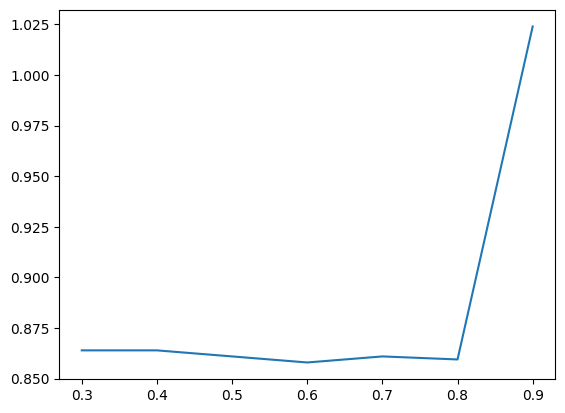

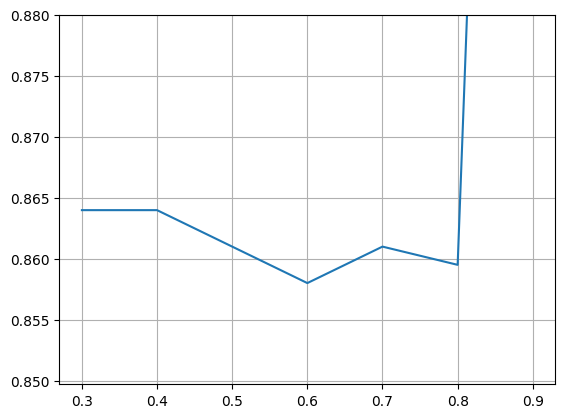

In [56]:
alphas = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
weighted_mean = []
print("v1")
for a in alphas:
    up = 0
    down = 0
    for index, row in dev_set.iterrows():
        if pd.isnull(row['v1_Errors % {}'.format(a)]):
            if row['v1_Errors {}'.format(a)] == 0:
                up += 0 * row['GT_Errors']
            else:
                up += 1 * row['GT_Errors']
        else:
            up += row['v1_Errors % {}'.format(a)] * row['GT_Errors']
        down += row['GT_Errors']
    weighted_mean.append(up/down) 
    print(a, up/down)
    
plt.plot(alphas, weighted_mean)
plt.yscale('linear')
#plt.ylim(top=0.9)
plt.show()

plt.plot(alphas, weighted_mean)
plt.yscale('linear')
plt.grid(True)
plt.ylim(top=0.88)
plt.show()

-----------
regex

In [94]:
def fix_errors(sent, ged, text_words, alpha = 0.5, delta = 4, betta = 0.9):
    #print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        #print(new_list_of_words)
        
        #print(new_mask.text)
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                dist = levenshtein(first[0], error_string)
                result.append((first[0], dist))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < delta:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [68]:
alphas = [0.4,0.5,0.6,0.7]
delta = [2,3,4,5,6]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='regex', alpha = a, delta = d)

            check = gt_bio(each_word(gt_text), fixed_text)
            dev_set.loc[index,'r_v1_Errors a{} d{}'.format(a,d)] = check.count(False)
            num_errors = check.count(False)

            gt_errors = gt_bio(each_word(gt_text), text_words).count(False)

            if gt_errors == 0:
                if num_errors > 0:
                    dev_set.loc[index,'r_v1_Errors % a{} d{}'.format(a,d)] = 1
                else:
                    dev_set.loc[index,'r_v1_Errors % a{} d{}'.format(a,d)] = 0
            else:
                dev_set.loc[index,'r_v1_Errors % a{} d{}'.format(a,d)] = check.count(False)/gt_errors

    dev_set.loc[index,'r_GT_Errors'] = gt_errors

100%|██████████████████████████████████████| 16/16 [5:45:51<00:00, 1296.95s/it]


In [95]:
alphas = [0.1,0.2,0.3]
delta = [2,3,4,5,6]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='regex', alpha = a, delta = d)

            check = gt_bio(each_word(gt_text), fixed_text)
            dev_set.loc[index,'r_v1_Errors a{} d{}'.format(a,d)] = check.count(False)
            num_errors = check.count(False)

            gt_errors = gt_bio(each_word(gt_text), text_words).count(False)

            if gt_errors == 0:
                if num_errors > 0:
                    dev_set.loc[index,'r_v1_Errors % a{} d{}'.format(a,d)] = 1
                else:
                    dev_set.loc[index,'r_v1_Errors % a{} d{}'.format(a,d)] = 0
            else:
                dev_set.loc[index,'r_v1_Errors % a{} d{}'.format(a,d)] = check.count(False)/gt_errors

    dev_set.loc[index,'r_GT_Errors'] = gt_errors

100%|███████████████████████████████████████| 16/16 [4:13:55<00:00, 952.20s/it]


In [27]:
dev_set_r = dev_set.filter(regex='r_', axis=1)
dev_set_r.mean()

r_v1_Errors 0.4      77.437500
r_v1_Errors % 0.4     0.940935
r_v1_Errors 0.5      77.312500
r_v1_Errors % 0.5     1.020422
r_v1_Errors 0.6      77.062500
r_v1_Errors % 0.6     1.013982
r_v1_Errors 0.7      77.187500
r_v1_Errors % 0.7     1.138982
r_GT_Errors          41.187500
dtype: float64

In [28]:
dev_set_r

r_v1_Errors 0.4  r_v1_Errors % 0.4  r_v1_Errors 0.5  r_v1_Errors % 0.5  \
0               1.0           1.000000              2.0           2.000000   
1               1.0           1.000000              1.0           1.000000   
2               0.0                NaN              0.0                NaN   
3               0.0                NaN              0.0                NaN   
4               0.0           0.000000              0.0           0.000000   
5               0.0           0.000000              0.0           0.000000   
6             854.0           3.795556            854.0           3.795556   
7               2.0           1.000000              2.0           1.000000   
8               7.0           0.388889              7.0           0.388889   
9              55.0           0.846154             52.0           0.800000   
10              1.0           1.000000              1.0           1.000000   
11            268.0           0.996283            268.0           0.996283   
12             17.0           0.566667             17.0           0.566667   
13              0.0                NaN              0.0                NaN   
14             30.0           0.697674             30.0           0.697674   
15              3.0                NaN              3.0                NaN   

    r_v1_Errors 0.6  r_v1_Errors % 0.6  r_v1_Errors 0.7  r_v1_Errors % 0.7  \
0               2.0           2.000000              2.0           2.000000   
1               1.0           1.000000              2.0           2.000000   
2               0.0                NaN              0.0                NaN   
3               0.0                NaN              0.0                NaN   
4               0.0           0.000000              0.0           0.000000   
5               0.0           0.000000              0.0           0.000000   
6             854.0           3.795556            854.0           3.795556   
7               2.0           1.000000              3.0           1.500000   
8               7.0           0.388889              7.0           0.388889   
9              50.0           0.769231             50.0           0.769231   
10              1.0           1.000000              1.0           1.000000   
11            268.0           0.996283            268.0           0.996283   
12             17.0           0.566667             17.0           0.566667   
13              0.0                NaN              0.0                NaN   
14             28.0           0.651163             28.0           0.651163   
15              3.0                NaN              3.0                NaN   

    r_GT_Errors  
0           1.0  
1           1.0  
2           0.0  
3           0.0  
4           2.0  
5           2.0  
6         225.0  
7           2.0  
8          18.0  
9          65.0  
10          1.0  
11        269.0  
12         30.0  
13          0.0  
14         43.0  
15          0.0

In [38]:
for a in alphas:
    up = 0
    down = 0
    for index, row in tqdm(dev_set_r.iterrows(), total = len(dev_set_r)):
        if pd.isnull(row['r_v1_Errors % {}'.format(a)]):
            if row['r_v1_Errors {}'.format(a)] == 0:
                up += 0 * row['r_GT_Errors']
            else:
                up += 1 * row['r_GT_Errors']
        else:
            up += row['r_v1_Errors % {}'.format(a)] * row['r_GT_Errors']
        down += row['r_GT_Errors']
    print(up/down)

100%|███████████████████████████████████████| 16/16 [00:00<00:00, 15756.95it/s]


1.8755690440060697


100%|████████████████████████████████████████| 16/16 [00:00<00:00, 7996.77it/s]


1.872534142640364


100%|███████████████████████████████████████| 16/16 [00:00<00:00, 15978.30it/s]


1.8664643399089529


100%|███████████████████████████████████████| 16/16 [00:00<00:00, 16545.58it/s]

1.8694992412746585


In [79]:
def fix_errors(sent, ged, text_words, alpha = 0.5, betta = 0.9, delta = 4):
    #print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        
        #print(new_list_of_words)
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)
        '''
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)
        
        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist, um['score']))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                result.append((first[0], first[2]*pow(betta,first[1])))
        candidate = sorted(result, key=lambda tup: tup[1])[-1]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < 4:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [62]:
alphas = [0.4,0.5,0.6]
betta = [0.9,0.8,0.7,0.6,0.5,0.4]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='regex', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'r_v2_Errors a{} b{}'.format(a, b)] = check.count(False)
            num_errors = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if num_errors > 0:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'r_GT_Errors'] = gt_errors

100%|██████████████████████████████████████| 16/16 [5:02:50<00:00, 1135.65s/it]


In [80]:
alphas = [0.6]
betta = [0.1]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='regex', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'r_v2_Errors a{} b{}'.format(a, b)] = check.count(False)
            num_errors = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if num_errors > 0:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'r_GT_Errors'] = gt_errors

100%|██████████████████████████████████████████| 16/16 [16:59<00:00, 63.71s/it]


In [81]:
alphas = [0.7]
betta = [0.5,0.4,0.3,0.2,0.1]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='regex', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'r_v2_Errors a{} b{}'.format(a, b)] = check.count(False)
            num_errors = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if num_errors > 0:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'r_GT_Errors'] = gt_errors

100%|███████████████████████████████████████| 16/16 [1:24:32<00:00, 317.02s/it]


In [87]:
alphas = [0.4,0.5]
betta = [0.3,0.2,0.1]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='regex', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'r_v2_Errors a{} b{}'.format(a, b)] = check.count(False)
            num_errors = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if num_errors > 0:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'r_GT_Errors'] = gt_errors

100%|███████████████████████████████████████| 16/16 [1:43:55<00:00, 389.74s/it]


In [17]:
dev_set_r2 = dev_set.filter(regex='r_v2', axis=1)
dev_set_r2

r_v2_Errors a0.4 b0.9  r_v2_Errors % a0.4 b0.9  r_v2_Errors a0.5 b0.9  \
0                    15.0                 1.000000                   15.0   
1                     7.0                 1.000000                    7.0   
2                     3.0                 1.000000                    3.0   
3                     0.0                      NaN                    0.0   
4                     2.0                 1.000000                    2.0   
5                     2.0                 1.000000                    1.0   
6                  1041.0                 1.017595                 1041.0   
7                     5.0                 1.250000                    5.0   
8                    31.0                 1.107143                   31.0   
9                    72.0                 1.014085                   73.0   
10                   10.0                 1.250000                   10.0   
11                  120.0                 0.618557                  120.0   
12                   38.0                 1.055556                   38.0   
13                    0.0                      NaN                    0.0   
14                   55.0                 1.037736                   55.0   
15                   13.0                 0.928571                   13.0   

    r_v2_Errors % a0.5 b0.9  r_v2_Errors a0.6 b0.9  r_v2_Errors % a0.6 b0.9  \
0                  1.000000                   15.0                 1.000000   
1                  1.000000                    7.0                 1.000000   
2                  1.000000                    3.0                 1.000000   
3                       NaN                    0.0                      NaN   
4                  1.000000                    2.0                 1.000000   
5                  0.500000                    1.0                 0.500000   
6                  1.017595                 1041.0                 1.017595   
7                  1.250000                    5.0                 1.250000   
8                  1.107143                   31.0                 1.107143   
9                  1.028169                   73.0                 1.028169   
10                 1.250000                   10.0                 1.250000   
11                 0.618557                  120.0                 0.618557   
12                 1.055556                   38.0                 1.055556   
13                      NaN                    0.0                      NaN   
14                 1.037736                   53.0                 1.000000   
15                 0.928571                   13.0                 0.928571   

    r_v2_Errors a0.7 b0.9  r_v2_Errors % a0.7 b0.9  r_v2_Errors a0.4 b0.8  \
0                    15.0                 1.000000                   15.0   
1                     7.0                 1.000000                    7.0   
2                     3.0                 1.000000                    3.0   
3                     0.0                      NaN                    0.0   
4                     2.0                 1.000000                    2.0   
5                     1.0                 0.500000                    2.0   
6                  1041.0                 1.017595                 1041.0   
7                     5.0                 1.250000                    5.0   
8                    31.0                 1.107143                   31.0   
9                    72.0                 1.014085                   72.0   
10                   10.0                 1.250000                   10.0   
11                  120.0                 0.618557                  120.0   
12                   38.0                 1.055556                   38.0   
13                    0.0                      NaN                    0.0   
14                   53.0                 1.000000                   55.0   
15                   13.0                 0.928571                   13.0   

    r_v2_Errors % a0.4 b0.8  ...  r_v2_E

In [18]:
dev_set_r2.mean()

r_v2_Errors a0.4 b0.9      88.375000
r_v2_Errors % a0.4 b0.9     1.019946
r_v2_Errors a0.5 b0.9      88.375000
r_v2_Errors % a0.5 b0.9     0.985238
r_v2_Errors a0.6 b0.9      88.250000
r_v2_Errors % a0.6 b0.9     0.982542
r_v2_Errors a0.7 b0.9      88.187500
r_v2_Errors % a0.7 b0.9     0.981536
r_v2_Errors a0.4 b0.8      88.375000
r_v2_Errors % a0.4 b0.8     1.019946
r_v2_Errors a0.5 b0.8      88.312500
r_v2_Errors % a0.5 b0.8     0.984232
r_v2_Errors a0.6 b0.8      88.187500
r_v2_Errors % a0.6 b0.8     0.981536
r_v2_Errors a0.7 b0.8      88.125000
r_v2_Errors % a0.7 b0.8     0.980530
r_v2_Errors a0.4 b0.7      88.375000
r_v2_Errors % a0.4 b0.7     1.019946
r_v2_Errors a0.5 b0.7      88.312500
r_v2_Errors % a0.5 b0.7     0.984232
r_v2_Errors a0.6 b0.7      88.187500
r_v2_Errors % a0.6 b0.7     0.981536
r_v2_Errors a0.7 b0.7      88.125000
r_v2_Errors % a0.7 b0.7     0.980530
r_v2_Errors a0.4 b0.6      88.375000
r_v2_Errors % a0.4 b0.6     1.019946
r_v2_Errors a0.5 b0.6      88.312500
r

TODO: replace max lenght of incorrect word to keep to a parameter (call it delta)

In [67]:
def fix_errors(sent, ged, text_words, alpha = 0.5, delta = 4, betta = 0.9):
    #print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        #print(new_list_of_words)
        
        #print(new_mask.text)
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                dist = levenshtein(first[0], error_string)
                result.append((first[0], dist))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < delta:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [26]:
alphas = [0.4,0.5,0.6,0.7]
delta = [2,3,4,5,6]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, delta = d)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v1_Errors a{} d{}'.format(a, d)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 1
                else:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 0
            else:
                dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|██████████████████████████████████████| 16/16 [5:35:35<00:00, 1258.47s/it]


In [138]:
alphas = [0.3]
delta = [7,8]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, delta = d)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v1_Errors a{} d{}'.format(a, d)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 1
                else:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 0
            else:
                dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|█████████████████████████████████████████| 16/16 [35:03<00:00, 131.46s/it]


In [140]:
alphas = [0.1,0.2]
delta = [2,3,4,5,6,7,8]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, delta = d)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v1_Errors a{} d{}'.format(a, d)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 1
                else:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 0
            else:
                dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|███████████████████████████████████████| 16/16 [3:41:28<00:00, 830.51s/it]


In [12]:
alphas = [0.4,0.5,0.6,0.7]
delta = [7]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, delta = d)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v1_Errors a{} d{}'.format(a, d)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 1
                else:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 0
            else:
                dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|█████████████████████████████████████████| 16/16 [58:03<00:00, 217.73s/it]


In [15]:
alphas = [0.5]
delta = [4,5]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, delta = d)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v1_Errors a{} d{}'.format(a, d)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 1
                else:
                    dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = 0
            else:
                dev_set.loc[index,'v1_Errors % a{} d{}'.format(a,d)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|█████████████████████████████████████████| 16/16 [29:34<00:00, 110.89s/it]


v2 + multiple mask

In [62]:
def fix_errors(sent, ged, text_words, alpha=0.5, betta = 0.9, delta = 4):
    checked_tokens = []
    to_fix = []

    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):

        if error == True:  # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged

        # print("Error: ", new_text_words[index])

        to_fix.append(index)
        if index < length-1 and new_ged[index + 1] == False:  # merge consecutive errors into one
            continue
        if len(to_fix)>1:
            error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        else:
            error_string_list = [new_text_words[to_fix[0]]]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text

        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)

        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''

        if len(error_string_list) > 1:
            mask_sequence = ""
            for j in range(len(error_string_list)):
                mask_sequence = mask_sequence + '<mask> '
        else:
            mask_sequence = "<mask>"

        new_list_of_words[len(checked_tokens)] = mask_sequence.strip() # next after checked_tokens part of list
        
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)

        best_token_candidate = []
        if len(error_string_list) > 1:
            for j in range(len(error_string_list)):
                first_token = []
                for um in candidates[j]:
                    dist = levenshtein(um['token_str'], error_string_list[j])
                    first_token.append((um['token_str'], dist, um['score']))
                '''
                first_token = sorted(first_token, key=lambda tup: tup[1])
                result = []
                for first in first_token:
                    dist = levenshtein(first[0], error_string)
                    result.append((first[0], dist))
                candidate = sorted(result, key=lambda tup: tup[1])[0]
                '''
                result = []
                for first in first_token:
                    result.append((first[0], first[2]*pow(betta,first[1])))
                best_token_candidate.append(sorted(result, key=lambda tup: tup[1])[-1])
        else:
            first_token = []
            for um in candidates:
                dist = levenshtein(um['token_str'], error_string_list[0])
                first_token.append((um['token_str'], dist, um['score']))
            '''
            first_token = sorted(first_token, key=lambda tup: tup[1])
            result = []
            for first in first_token:
                dist = levenshtein(first[0], error_string)
                result.append((first[0], dist))
            candidate = sorted(result, key=lambda tup: tup[1])[0]
            '''
            result = []
            for first in first_token:
                result.append((first[0], first[2]*pow(betta,first[1])))
            best_token_candidate.append(sorted(result, key=lambda tup: tup[1])[-1])

        for j, candidate in enumerate(best_token_candidate):
            if levenshtein(candidate[0], error_string_list[j].strip()) <= len(error_string_list[j]) * alpha or len(error_string_list[j]) < 4:
                if len(candidate[0]) != 0:
                    if " " in candidate[0].strip():
                        candidatelist = candidate[0].strip().split(" ")
                        checked_tokens = checked_tokens + candidatelist
                    else:
                        checked_tokens.append(candidate[0].strip())
            else:
                candidatelist = error_string.strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            to_fix = []

    return checked_tokens

In [64]:
alphas = [0.4,0.5,0.6]
betta = [0.9,0.8,0.7,0.6,0.5]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v3_Errors a{} b{}'.format(a, b)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|███████████████████████████████████████| 16/16 [3:53:18<00:00, 874.90s/it]


In [69]:
alphas = [0.7]
betta = [0.7,0.6,0.5]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v3_Errors a{} b{}'.format(a, b)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|█████████████████████████████████████████| 16/16 [47:20<00:00, 177.51s/it]


In [63]:
alphas = [0.7]
betta = [0.9,0.8]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            dev_set.loc[index,'v3_Errors a{} b{}'.format(a, b)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = 0
            else:
                dev_set.loc[index,'v3_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|█████████████████████████████████████████| 16/16 [29:25<00:00, 110.35s/it]


In [53]:
alphas = [0.5]
betta = [0.9]
delta = [3,4,5]
for index, row in tqdm(dev_set.iterrows(), total = len(dev_set), position = 0):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            for d in delta:
                ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b, delta=d)

                check = gt_bio(correct_text_words, fixed_text)
                dev_set.loc[index,'v3_Errors a{} b{} d{}'.format(a, b, d)] = check.count(False)

                gt_errors = gt_bio(correct_text_words, text_words).count(False)
                if gt_errors == 0:
                    if check.count(False) > 0:
                        dev_set.loc[index,'v3_Errors % a{} b{} d{}'.format(a, b, d)] = 1
                    else:
                        dev_set.loc[index,'v3_Errors % a{} b{} d{}'.format(a, b, d)] = 0
                else:
                    dev_set.loc[index,'v3_Errors % a{} b{} d{}'.format(a, b, d)] = check.count(False)/gt_errors

    dev_set.loc[index,'GT_Errors'] = gt_errors

100%|█████████████████████████████████████████| 16/16 [50:56<00:00, 191.02s/it]


In [58]:
v3 = dev_set.filter(regex='v3_Errors', axis=1)

In [59]:
v3['GT_Errors'] = dev_set['GT_Errors']

C:\Users\Anton\AppData\Local\Temp\ipykernel_27924\4266467576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v3['GT_Errors'] = dev_set['GT_Errors']


In [60]:
v3

v3_Errors a0.5 b0.9  v3_Errors % a0.5 b0.9  v3_Errors a0.6 b0.9  \
0                   1.0               1.000000                  1.0   
1                   1.0               1.000000                  1.0   
2                   0.0                    NaN                  0.0   
3                   0.0                    NaN                  0.0   
4                   5.0               2.500000                  5.0   
5                   2.0               1.000000                  2.0   
6                1646.0               7.064378               1646.0   
7                   5.0               2.500000                  5.0   
8                  41.0               1.576923                 41.0   
9                 110.0               1.692308                110.0   
10                  2.0               2.000000                  2.0   
11                 61.0               0.237354                 61.0   
12                 53.0               1.472222                 53.0   
13                  0.0                    NaN                  0.0   
14                241.0               5.604651                241.0   
15                  4.0                    NaN                  4.0   

    v3_Errors % a0.6 b0.9  v3_Errors a0.5 b0.8  v3_Errors % a0.5 b0.8  \
0                1.000000                  1.0               1.000000   
1                1.000000                  1.0               1.000000   
2                     NaN                  0.0                    NaN   
3                     NaN                  0.0                    NaN   
4                2.500000                  5.0               2.500000   
5                1.000000                  2.0               1.000000   
6                7.064378               1646.0               7.064378   
7                2.500000                  5.0               2.500000   
8                1.576923                 41.0               1.576923   
9                1.692308                110.0               1.692308   
10               2.000000                  2.0               2.000000   
11               0.237354                 61.0               0.237354   
12               1.472222                 53.0               1.472222   
13                    NaN                  0.0                    NaN   
14               5.604651                241.0               5.604651   
15                    NaN                  4.0                    NaN   

    v3_Errors a0.6 b0.8  v3_Errors % a0.6 b0.8  v3_Errors a0.5 b0.7  \
0                   1.0               1.000000                  1.0   
1                   1.0               1.000000                  1.0   
2                   0.0                    NaN                  0.0   
3                   0.0                    NaN                  0.0   
4                   5.0               2.500000                  5.0   
5                   2.0               1.000000                  2.0   
6                1646.0               7.064378               1646.0   
7                   5.0               2.500000                  5.0   
8                  41.0               1.576923                 41.0   
9                 110.0               1.692308                110.0   
10                  2.0               2.000000                  2.0   
11                 61.0               0.237354                 61.0   
12                 53.0               1.472222                 53.0   
13                  0.0                    NaN                  0.0   
14                241.0               5.604651                241.0   
15                  4.0                    NaN                  4.0   

    v3_Errors % a0.5 b0.7  ...  v3_Errors % a0.4 b0.6  v3_Errors a0.4 b0.5  \
0                1.000000  ...               1.000000                  1.0   
1                1.000000  ...               1.000000                  1.0   
2                     NaN  ...                    NaN                  0.0   
3                     NaN  ...    

In [33]:
v3.mean()

v3_Errors a0.5 b0.9      135.750000
v3_Errors % a0.5 b0.9      2.303986
v3_Errors a0.6 b0.9      135.750000
v3_Errors % a0.6 b0.9      2.303986
v3_Errors a0.5 b0.8      135.750000
v3_Errors % a0.5 b0.8      2.303986
v3_Errors a0.6 b0.8      135.750000
v3_Errors % a0.6 b0.8      2.303986
v3_Errors a0.5 b0.7      135.750000
v3_Errors % a0.5 b0.7      2.303986
v3_Errors a0.6 b0.7      135.750000
v3_Errors % a0.6 b0.7      2.303986
v3_Errors a0.5 b0.6      135.750000
v3_Errors % a0.5 b0.6      2.303986
v3_Errors a0.6 b0.6      135.750000
v3_Errors % a0.6 b0.6      2.303986
v3_Errors a0.5 b0.5      135.750000
v3_Errors % a0.5 b0.5      2.303986
v3_Errors a0.6 b0.5      135.750000
v3_Errors % a0.6 b0.5      2.303986
v3_Errors a0.4 b0.9      135.750000
v3_Errors % a0.4 b0.9      2.303986
v3_Errors a0.4 b0.8      135.750000
v3_Errors % a0.4 b0.8      2.303986
v3_Errors a0.4 b0.7      135.750000
v3_Errors % a0.4 b0.7      2.303986
v3_Errors a0.4 b0.6      135.750000
v3_Errors % a0.4 b0.6      2

In [40]:
print(dev_set.columns.tolist())

['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'OCR_Text', 'Ground_True', 'Checked', 'v1_Errors 0.3', 'v1_Errors 0.4', 'v1_Errors 0.5', 'v1_Errors 0.6', 'v1_Errors 0.7', 'v1_Errors 0.8', 'v1_Errors 0.9', 'GT_Errors', 'v1_Errors % 0.3', 'v1_Errors % 0.4', 'v1_Errors % 0.5', 'v1_Errors % 0.6', 'v1_Errors % 0.7', 'v1_Errors % 0.8', 'v1_Errors % 0.9', 'v2_Errors a0.5 b0.9', 'v2_Errors % a0.5 b0.9', 'v2_Errors a0.6 b0.9', 'v2_Errors % a0.6 b0.9', 'v2_Errors a0.5 b0.8', 'v2_Errors % a0.5 b0.8', 'v2_Errors a0.6 b0.8', 'v2_Errors % a0.6 b0.8', 'v2_Errors a0.5 b0.7', 'v2_Errors % a0.5 b0.7', 'v2_Errors a0.6 b0.7', 'v2_Errors % a0.6 b0.7', 'v2_Errors a0.5 b0.6', 'v2_Errors % a0.5 b0.6', 'v2_Errors a0.6 b0.6', 'v2_Errors % a0.6 b0.6', 'v2_Errors a0.5 b0.5', 'v2_Errors % a0.5 b0.5', 'v2_Errors a0.6 b0.5', 'v2_Errors % a0.6 b0.5', 'r_v1_Errors 0.4', 'r_v1_Errors % 0.4', 'r_v1_Errors 0.5', 'r_v1_Errors % 0.5', 'r_v1_Errors 0.6', 'r_v1_Errors % 0.6', 'r_v1_Errors 0.7',

In [99]:
dev_set.to_csv("dev_set2.csv")

In [6]:
dev_set = pd.read_csv("dev_set2.csv")

In [96]:
dev_set.filter(regex='r_v1_Errors %', axis=1).mean()

r_v1_Errors % 0.4        0.940935
r_v1_Errors % 0.5        1.020422
r_v1_Errors % 0.6        1.013982
r_v1_Errors % 0.7        1.138982
r_v1_Errors % a0.4 d2    0.939653
r_v1_Errors % a0.4 d3    0.939653
r_v1_Errors % a0.4 d4    0.940935
r_v1_Errors % a0.4 d5    0.940935
r_v1_Errors % a0.4 d6    0.937059
r_v1_Errors % a0.5 d2    1.019140
r_v1_Errors % a0.5 d3    1.019140
r_v1_Errors % a0.5 d4    1.020422
r_v1_Errors % a0.5 d5    1.020422
r_v1_Errors % a0.5 d6    1.016546
r_v1_Errors % a0.6 d2    1.012700
r_v1_Errors % a0.6 d3    1.012700
r_v1_Errors % a0.6 d4    1.013982
r_v1_Errors % a0.6 d5    1.013982
r_v1_Errors % a0.6 d6    1.013982
r_v1_Errors % a0.7 d2    1.137700
r_v1_Errors % a0.7 d3    1.137700
r_v1_Errors % a0.7 d4    1.138982
r_v1_Errors % a0.7 d5    1.138982
r_v1_Errors % a0.7 d6    1.138982
r_v1_Errors % a0.1 d2    1.033302
r_v1_Errors % a0.1 d3    1.033302
r_v1_Errors % a0.1 d4    1.034585
r_v1_Errors % a0.1 d5    1.028771
r_v1_Errors % a0.1 d6    1.024895
r_v1_Errors % 

In [22]:
pd.set_option('display.max_rows', 500)
print(dev_set.filter(regex='v2_Errors %', axis=1).mean())

v2_Errors % a0.4 b0.9      0.822854
v2_Errors % a0.5 b0.9      0.821572
v2_Errors % a0.6 b0.9      0.774091
v2_Errors % a0.4 b0.8      0.820916
v2_Errors % a0.5 b0.8      0.819634
v2_Errors % a0.6 b0.8      0.775373
v2_Errors % a0.4 b0.7      0.820916
v2_Errors % a0.5 b0.7      0.818352
v2_Errors % a0.6 b0.7      0.772809
v2_Errors % a0.4 b0.6      0.820916
v2_Errors % a0.5 b0.6      0.817070
v2_Errors % a0.6 b0.6      0.772809
v2_Errors % a0.4 b0.5      0.820916
v2_Errors % a0.5 b0.5      0.817070
v2_Errors % a0.6 b0.5      0.853578
r_v2_Errors % a0.4 b0.9    0.806255
r_v2_Errors % a0.5 b0.9    0.805249
r_v2_Errors % a0.6 b0.9    0.802554
r_v2_Errors % a0.4 b0.8    0.806255
r_v2_Errors % a0.5 b0.8    0.804243
r_v2_Errors % a0.6 b0.8    0.802554
r_v2_Errors % a0.4 b0.7    0.804908
r_v2_Errors % a0.5 b0.7    0.802895
r_v2_Errors % a0.6 b0.7    0.800200
r_v2_Errors % a0.4 b0.6    0.804908
r_v2_Errors % a0.5 b0.6    0.801889
r_v2_Errors % a0.6 b0.6    0.800200
r_v2_Errors % a0.4 b0.5    0

In [70]:
dev_set.filter(regex='v3_Errors %', axis=1).mean()

v3_Errors % a0.4 b0.9    1.699284
v3_Errors % a0.5 b0.9    1.700566
v3_Errors % a0.6 b0.9    1.617233
v3_Errors % a0.4 b0.8    1.613387
v3_Errors % a0.5 b0.8    1.614669
v3_Errors % a0.6 b0.8    1.614669
v3_Errors % a0.4 b0.7    1.613387
v3_Errors % a0.5 b0.7    1.614669
v3_Errors % a0.6 b0.7    1.519797
v3_Errors % a0.4 b0.6    1.610822
v3_Errors % a0.5 b0.6    1.612104
v3_Errors % a0.6 b0.6    1.519797
v3_Errors % a0.4 b0.5    1.527489
v3_Errors % a0.5 b0.5    1.528771
v3_Errors % a0.6 b0.5    1.519797
v3_Errors % a0.7 b0.7    1.513387
v3_Errors % a0.7 b0.6    1.513387
v3_Errors % a0.7 b0.5    1.509540
v3_Errors % a0.7 b0.9    1.614669
v3_Errors % a0.7 b0.8    1.610822
dtype: float64

Max lenght to keep doesn't metter: for delta from 2 to 6 no any varioation im mean % -> 0.708525 for alpha 0.5 and any delta

Best alpha for v1 is between 0.4 and 0.5 (with 0.5 better) -> 0.709807 for alpha 0.5

r_v1_Errors % 0.4    0.940935

v2 is worse than v1 for all values, best score 0.772809 for alpha 0.6 and beta 0.6-0.7 (alfa 0.4-0.6, betta 0.5-0.9)

r_v2 have best score 0.789259 in values a0.6 b0.4

v3 have best score of 1.519797 for alpha 0.6 and beta between 0.5 and 0.7   ///  1.509540 for alpha 0.7 beta 0.5

v1 plot

In [41]:
alpha = [0.4,0.5,0.6,0.7]
delta = [2,3,4,5,6]
score = [[0.4,2,0.710433],[0.4,3,0.710433],[0.4,4,0.710433],[0.4,5,0.710433],[0.4,6,0.710433],[0.4,7,0.750788],
         [0.5,2,0.708525],[0.5,3,0.708525],[0.5,4,0.708525],[0.5,5,0.708525],[0.5,6,0.708525],[0.5,7,0.748880],
         [0.6,2,0.828367],[0.6,3,0.828367],[0.6,4,0.828367],[0.6,5,0.828367],[0.6,6,0.828367],[0.6,7,0.872598],
         [0.7,2,0.953367],[0.7,3,0.953367],[0.7,4,0.953367],[0.7,5,0.953367],[0.7,6,0.953367],[0.7,7,0.997598],
         [0.3,2,0.710433],[0.3,3,0.710433],[0.3,4,0.711715],[0.3,5,0.711715],[0.3,6,0.707839],[0.3,7,0.750788],
         [0.2,2,0.716247],[0.2,3,0.716247],[0.2,4,0.717529],[0.2,5,0.711715],[0.2,6,0.707839],[0.2,7,0.750788],
         [0.1,2,0.804083],[0.1,3,0.804083],[0.1,4,0.805365],[0.1,5,0.799551],[0.1,6,0.795675],[0.1,7,0.838624]
        ]
x, y, z = zip(*score)

In [42]:
from matplotlib import cm

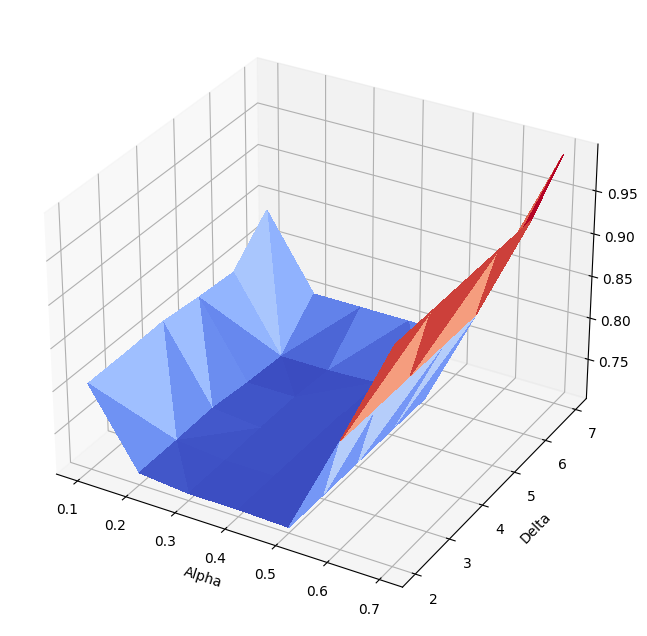

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array(x),np.array(y),np.array(z), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Alpha")
ax.set_ylabel("Delta")
plt.savefig('v1.png')
plt.show()

In [7]:
score = [[0.1,0.795675],
         [0.2,0.707839],
         [0.3,0.707839],
         [0.4,0.710433],
         [0.5,0.708525],
         [0.6,0.828367],
         [0.7,0.953367],]
x, y = zip(*score)

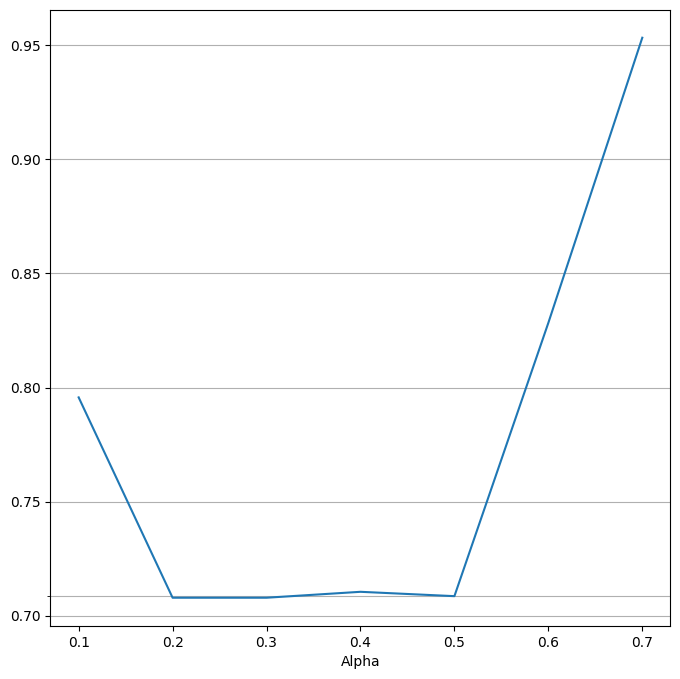

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.set_yticks([0.708525], minor=True)
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Alpha")
plt.savefig('v1_1.png')
plt.show()

v2

In [46]:
score = [[0.4,0.9,0.822854],[0.4,0.8,0.820916],[0.4,0.7,0.820916],[0.4,0.6,0.820916],[0.4,0.5,0.820916],[0.4,0.4,0.737582],[0.4,0.3,0.737582],[0.4,0.2,0.737582],[0.4,0.1,0.737582],
         [0.5,0.9,0.821572],[0.5,0.8,0.819634],[0.5,0.7,0.818352],[0.5,0.6,0.817070],[0.5,0.5,0.817070],[0.5,0.4,0.735674],[0.5,0.3,0.735674],[0.5,0.2,0.735674],[0.5,0.1,0.733736],
         [0.6,0.9,0.774091],[0.6,0.8,0.775373],[0.6,0.7,0.772809],[0.6,0.6,0.772809],[0.6,0.5,0.853578],[0.6,0.4,0.855516],[0.6,0.3,0.855516],[0.6,0.2,0.853578],[0.6,0.1,0.853578],
         [0.7,0.9,0.857424],[0.7,0.8,0.857424],[0.7,0.7,0.856142],[0.7,0.6,0.936285],[0.7,0.5,0.852952],[0.7,0.4,0.979234],[0.7,0.3,0.937567],[0.7,0.2,0.937567],[0.7,0.1,0.937567]]

x, y, z = zip(*score)

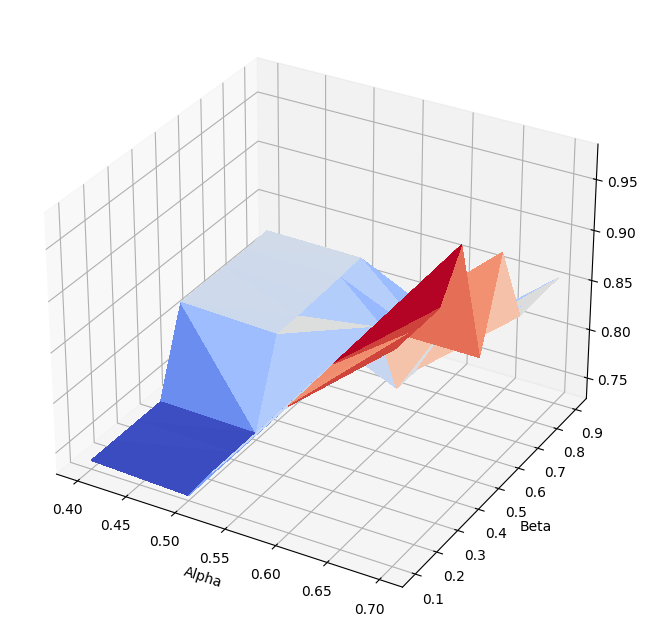

In [47]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array(x),np.array(y),np.array(z), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta")
plt.savefig('v2.png')
plt.show()

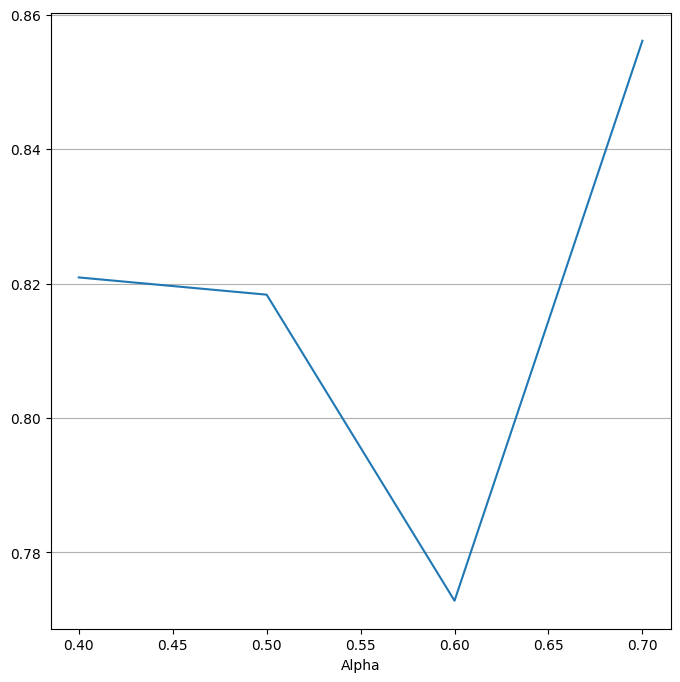

In [16]:
score = [[0.4,0.820916],
         [0.5,0.818352],
         [0.6,0.772809],
         [0.7,0.856142]]
x, y = zip(*score)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Alpha")
plt.savefig('v2_1.png')
plt.show()

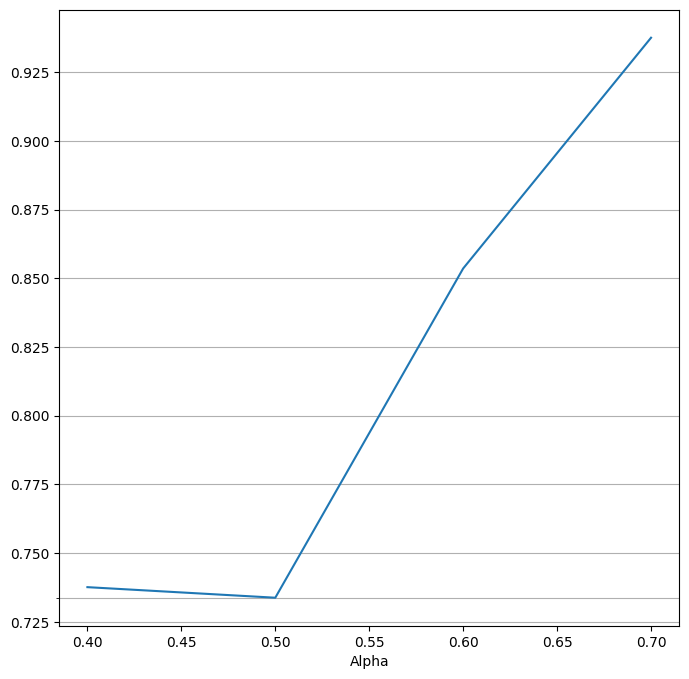

In [17]:
score = [[0.4,0.737582],
         [0.5,0.733736],
         [0.6,0.853578],
         [0.7,0.937567]]
x, y = zip(*score)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.set_yticks([0.733736], minor=True)
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Alpha")
plt.savefig('v2_2.png')
plt.show()

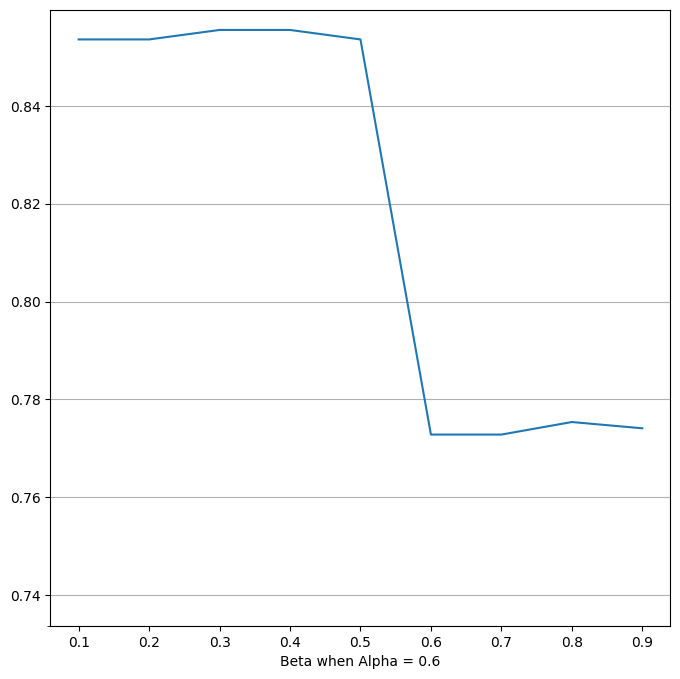

In [9]:
score = [[0.9,0.774091],[0.8,0.775373],[0.7,0.772809],[0.6,0.772809],[0.5,0.853578],[0.4,0.855516],[0.3,0.855516],[0.2,0.853578],[0.1,0.853578]]
x, y = zip(*score)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.set_yticks([0.733736], minor=True)
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Beta when Alpha = 0.6")
plt.savefig('v2_2.png')
plt.show()

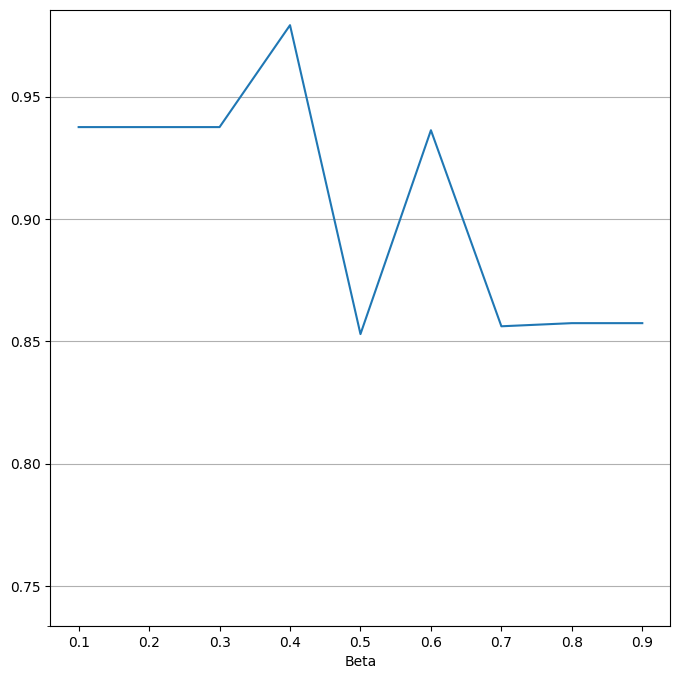

In [10]:
score = [[0.9,0.857424],[0.8,0.857424],[0.7,0.856142],[0.6,0.936285],[0.5,0.852952],[0.4,0.979234],[0.3,0.937567],[0.2,0.937567],[0.1,0.937567]]
x, y = zip(*score)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.set_yticks([0.733736], minor=True)
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Beta when Alpha = 0.7")
plt.savefig('v2_2.png')
plt.show()

v3

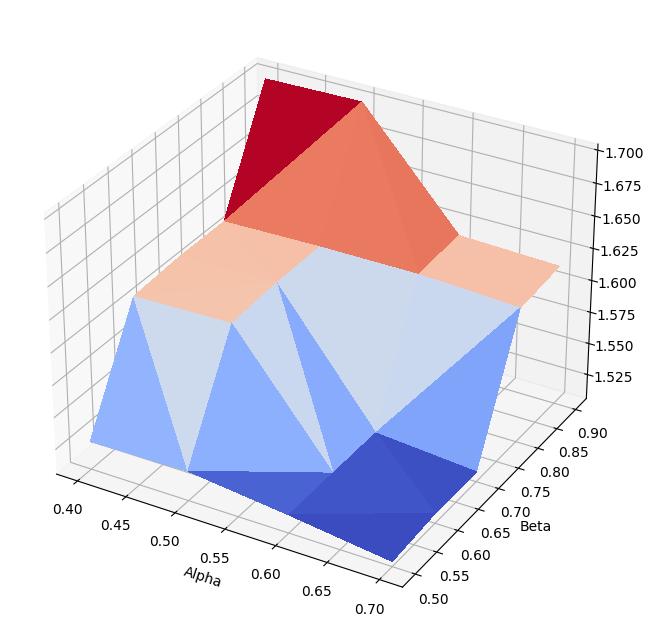

In [50]:
score = [[0.4,0.9,1.699284],[0.4,0.8,1.613387],[0.4,0.7,1.613387],[0.4,0.6,1.610822],[0.4,0.5,1.527489],
         [0.5,0.9,1.700566],[0.5,0.8,1.614669],[0.5,0.7,1.614669],[0.5,0.6,1.612104],[0.5,0.5,1.528771],
         [0.6,0.9,1.617233],[0.6,0.8,1.614669],[0.6,0.7,1.519797],[0.6,0.6,1.519797],[0.6,0.5,1.519797],
         [0.7,0.9,1.614669],[0.7,0.8,1.610822],[0.7,0.7,1.513387],[0.7,0.6,1.513387],[0.7,0.5,1.509540]]

x, y, z = zip(*score)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array(x),np.array(y),np.array(z), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta")
plt.savefig('v3.png')
plt.show()

r_v1

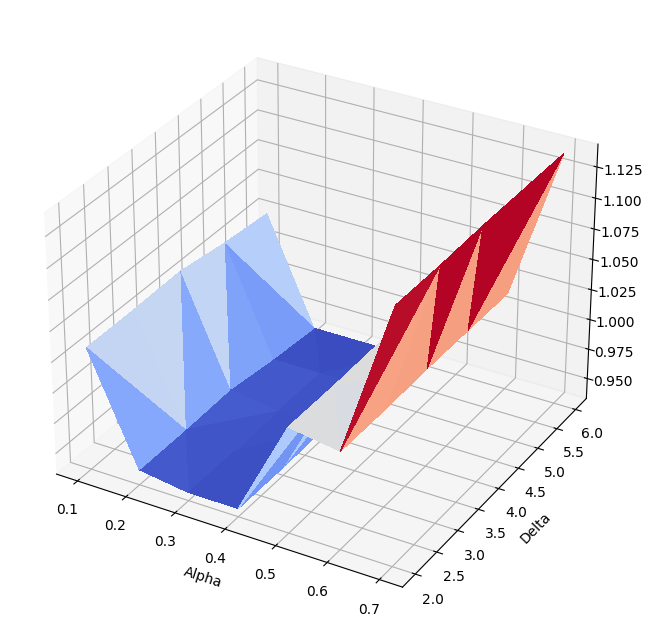

In [51]:
score = [[0.1,2,1.033302],[0.1,3,1.033302],[0.1,4,1.034585],[0.1,5,1.028771],[0.1,6,1.024895],
         [0.2,2,0.945467],[0.2,3,0.945467],[0.2,4,0.946749],[0.2,5,0.940935],[0.2,6,0.937059],
         [0.3,2,0.939653],[0.3,3,0.939653],[0.3,4,0.940935],[0.3,5,0.940935],[0.3,6,0.937059],
         [0.4,2,0.939653],[0.4,3,0.939653],[0.4,4,0.940935],[0.4,5,0.940935],[0.4,6,0.937059],
         [0.5,2,1.019140],[0.5,3,1.019140],[0.5,4,1.020422],[0.5,5,1.020422],[0.5,6,1.016546],
         [0.6,2,1.012700],[0.6,3,1.012700],[0.6,4,1.013982],[0.6,5,1.013982],[0.6,6,1.013982],
         [0.7,2,1.137700],[0.7,3,1.137700],[0.7,4,1.138982],[0.7,5,1.138982],[0.7,6,1.138982],
        ]

x, y, z = zip(*score)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array(x),np.array(y),np.array(z), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Alpha")
ax.set_ylabel("Delta")
plt.savefig('r_v1.png')
plt.show()

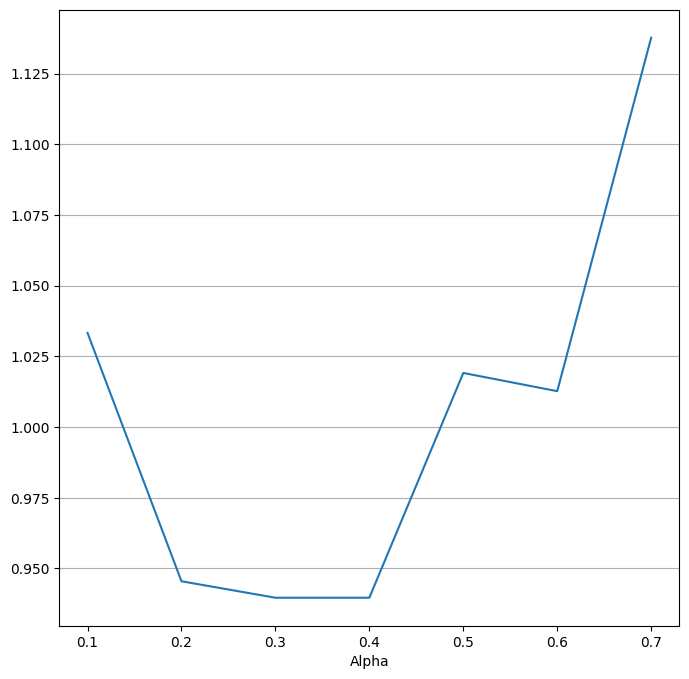

In [11]:
score = [[0.1,1.033302],
         [0.2,0.945467],
         [0.3,0.939653],
         [0.4,0.939653],
         [0.5,1.019140],
         [0.6,1.012700],
         [0.7,1.137700]]
x, y = zip(*score)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Alpha")
plt.savefig('r_v1_1.png')
plt.show()

r_v2

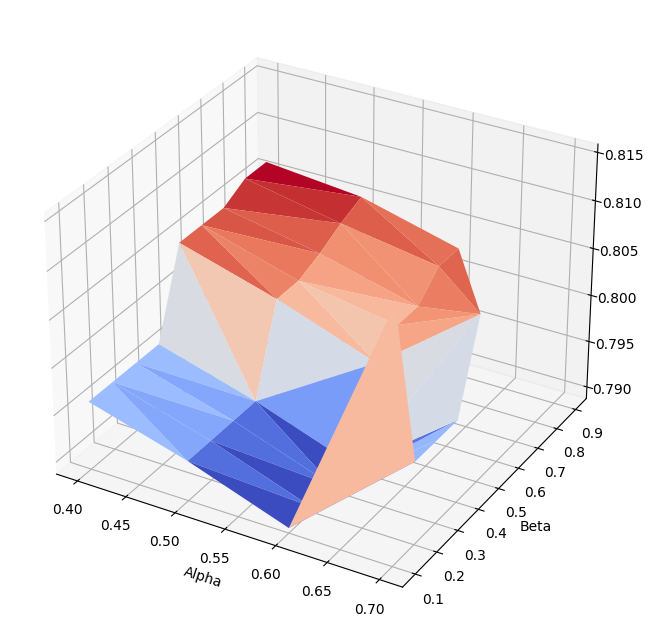

In [53]:
score = [[0.4,0.9,0.806255],[0.4,0.8,0.806255],[0.4,0.7,0.804908],[0.4,0.6,0.804908],[0.4,0.5,0.804908],[0.4,0.4,0.795979],[0.4,0.3,0.795979],[0.4,0.2,0.795979],[0.4,0.1,0.795979],
         [0.5,0.9,0.805249],[0.5,0.8,0.804243],[0.5,0.7,0.802895],[0.5,0.6,0.801889],[0.5,0.5,0.801889],[0.5,0.4,0.792961],[0.5,0.3,0.792961],[0.5,0.2,0.792961],[0.5,0.1,0.792961],
         [0.6,0.9,0.802554],[0.6,0.8,0.802554],[0.6,0.7,0.800200],[0.6,0.6,0.800200],[0.6,0.5,0.798188],[0.6,0.4,0.789259],[0.6,0.3,0.789259],[0.6,0.2,0.789259],[0.6,0.1,0.789259],
                                                                                     [0.7,0.5,0.806380],[0.7,0.4,0.797451],[0.7,0.3,0.797451],[0.7,0.2,0.797451],[0.7,0.1,0.815309],
        ]

x, y, z = zip(*score)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array(x),np.array(y),np.array(z), cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta")
plt.savefig('r_v2.png')
plt.show()

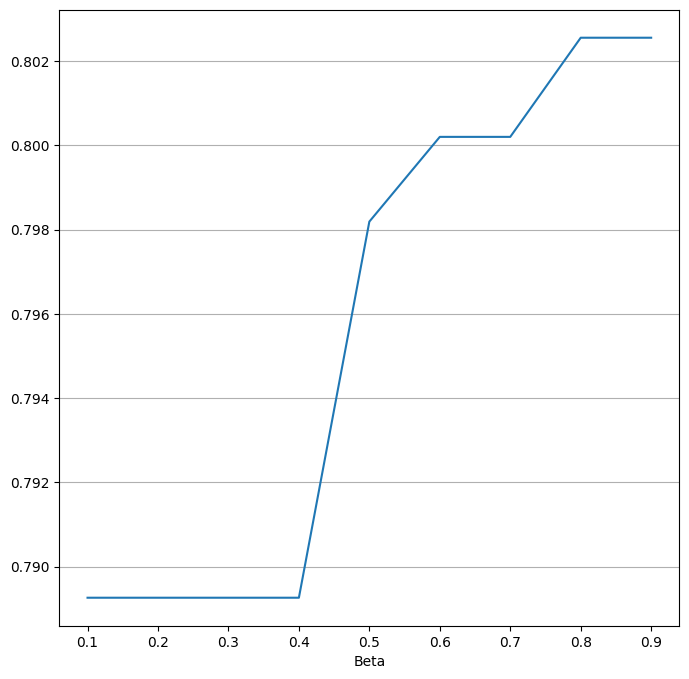

In [12]:
score = [[0.9,0.802554],[0.8,0.802554],[0.7,0.800200],[0.6,0.800200],[0.5,0.798188],[0.4,0.789259],[0.3,0.789259],[0.2,0.789259],[0.1,0.789259]]
x, y = zip(*score)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Beta")
plt.savefig('r_v2_1.png')
plt.show()

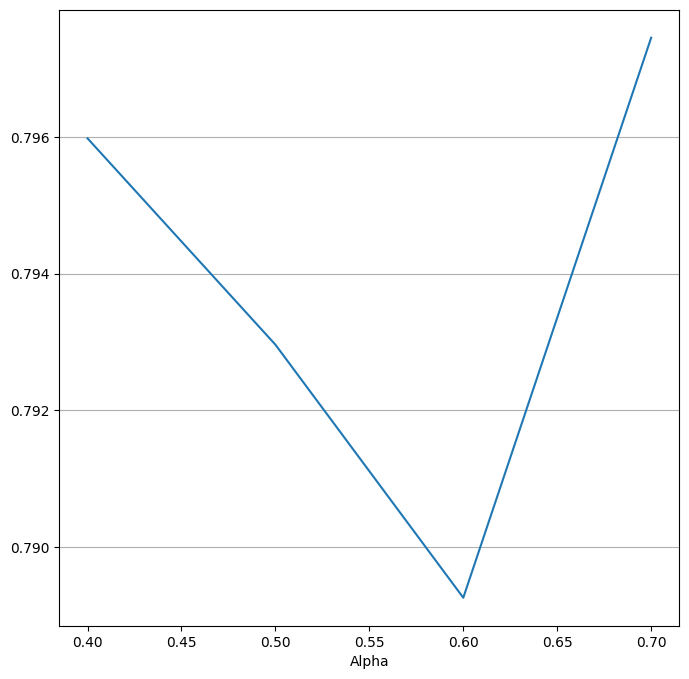

In [13]:
score = [[0.4,0.795979],
         [0.5,0.792961],
         [0.6,0.789259],
         [0.7,0.797451]]
x, y = zip(*score)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.array(x),np.array(y))
ax.yaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='major')
ax.set_xlabel("Alpha")
plt.savefig('r_v2_2.png')
plt.show()

In [18]:
dev_set['Unnamed: 0']

0     33
1     23
2     40
3     37
4      2
5      3
6     31
7     26
8     46
9     27
10    28
11    49
12    21
13    34
14    19
15    42
Name: Unnamed: 0, dtype: int64

In [12]:
test_set = GT_df.copy().drop(dev_set['Unnamed: 0'])
test_set

OCR_Text  \
0   MORINI, Segretmio, legge: (C Per gli intervent...   
1   GIORGIO NEBBIA. Solo per ricordare che anche i...   
4   due controllate dal gruppo FIAT tramite la Gil...   
5   BATTISTI NI         21208 Sostituzione di un C...   
6   PRESIDENTE . Sono stati presentati i seguenti ...   
7   ADELE FACCIO. Noi chiediamo che le disposizion...   
8   ERNESTO STAJANO, Presidente della IX Commissio...   
9   S. 1695. — Senatori MORA ed altri: «Modifiche ...   
10  GALDO. Signor Presidente, onorevoli col leghi,...   
11  ROBERTO OCCHIUTO. Presidente, il collega Vella...   
12  MICHELE VIETTI. Concludo, Presidente, rilevand...   
13  TESSARI ALESSANDRO. Signor Presidente, ho asco...   
14  PRESIDENTE. Passiamo ai voti. Indico la votazi...   
15  SALVATORE CHERCHI, Relatore per la maggioranza...   
16  ROBERTO CICCIOMESSERE. Dicevo, si gnora Presid...   
17  PRESIDENTE . Passiamo all'esame degl i ordini ...   
18  le privatizzazioni attinenti all’ENEL. In rela...   
20  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...   
22  COLAJANNI . No, a due aree monetarie , una eur...   
24  PRESIDENTE. Non essendovi più iscritti a parla...   
25  CESE: « Norme per la messa al bando delle mine...   
29  TAVERNA. Signor Presidente, onorevol i collegh...   
30  DI VITTORIO. La Commissione ha re spinto anche...   
32  FACCIO ed altri: «Abrogazione dell e norme di ...   
36  PRESIDENTE. Nessun altro chiedendo d i parlare...   
38  XIV LEGISLATURA — DISCUSSIONI — SEDUTA DEL 23 ...   
41  XVI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 12 ...   
43  TARCISIO GITTI, Relatare per la maggioranza. N...   
44  SILVANO LABRIOLA, Presidente della I Commissio...   
45  DANIELE MARANTELLI. Signor Presidente, rappres...   
47  PRESIDENTE . Avverto che essend o pervenuta ri...   
48  PRESIDENTE. Passiamo ai voti. Indı̀co la votaz...   

                                          Ground_True  Checked  
0   MORINI, Segretario, legge: « Per gli intervent...     True  
1   GIORGIO NEBBIA. Solo per ricordare che anche i...     True  
4   due controllate dal gruppo FIAT tramite la Gil...     True  
5   BATTISTINI         21208 Sostituzione di un Co...     True  
6   PRESIDENTE. Sono stati presentati i seguenti e...     True  
7   ADELE FACCIO. Noi chiediamo che le disposizion...     True  
8   ERNESTO STAJANO, Presidente della IX Commissio...     True  
9   S. 1695. — Senatori MORA ed altri: «Modifiche ...     True  
10  GALDO. Signor Presidente, onorevoli colleghi, ...     True  
11  ROBERTO OCCHIUTO. Presidente, il collega Vella...     True  
12  MICHELE VIETTI. Concludo, Presidente, rilevand...     True  
13  TESSARI ALESSANDRO. Signor Presidente, ho asco...     True  
14  PRESIDENTE. Passiamo ai voti. Indico la votazi...     True  
15  SALVATORE CHERCHI, Relatore per la maggioranza...     True  
16  ROBERTO CICCIOMESSERE. Dicevo, signora Preside...     True  
17  PRESIDENTE. Passiamo all'esame degli ordini de...     True  
18  le privatizzazioni attinenti all’ENEL. In rela...     True  
20  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...     True  
22  COLAJANNI. No, a due aree monetarie, una europ...     True  
24  PRESIDENTE. Non essendovi più iscritti a parla...     True  
25  LECCESE: « Norme per la messa al bando delle m...     True  
29  TAVERNA. Signor Presidente, onorevoli colleghi...     True  
30  DI VITTORIO. La Commissione ha respinto anche ...     True  
32  FACCIO ed altri: «Abrogazione delle norme di i...     True  
36  PRESIDENTE. Nessun altro chiedendo di parlare,...     True  
38  XIV LEGISLATURA — DISCUSSIONI — SEDUTA DEL 23 ...     True  
41  XVI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 12 ...     True  
43  TARCISIO GITTI, Relatare per la maggioranza. N...     True  
44  SILVANO LABRIOLA, Presidente della I Commissio...     True  
45  DANIELE MARANTELLI. Signor Presidente, rappres...     True  
47  PRESIDENTE. Avverto che essendo pervenuta rich...     True  
48  PRESIDENTE. Passiamo ai voti. Indı̀co la votaz...     True

In [17]:
len(test_set) + len(dev_set) == len(GT_df)

True

v1 alpha 0.3 and 0.5

In [19]:
def fix_errors(sent, ged, text_words, alpha = 0.5, delta = 4, betta = 0.9):
    #print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        #print(new_list_of_words)
        
        #print(new_mask.text)
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)

        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                dist = levenshtein(first[0], error_string)
                result.append((first[0], dist))
        candidate = sorted(result, key=lambda tup: tup[1])[0]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < delta:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [20]:
alphas = [0.3,0.5]
delta = [4]
for index, row in tqdm(test_set.iterrows(), total = len(dev_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
        
    for a in alphas:
        for d in delta:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, delta = d)

            check = gt_bio(correct_text_words, fixed_text)
            test_set.loc[index,'v1_Errors a{}'.format(a)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    test_set.loc[index,'v1_Errors % a{}'.format(a)] = 1
                else:
                    test_set.loc[index,'v1_Errors % a{}'.format(a)] = 0
            else:
                test_set.loc[index,'v1_Errors % a{}'.format(a)] = check.count(False)/gt_errors

    test_set.loc[index,'GT_Errors'] = gt_errors

32it [43:29, 81.54s/it]


v2 alpha 0.5 beta 0.1

In [27]:
def fix_errors(sent, ged, text_words, alpha = 0.5, betta = 0.9, delta = 4):
    print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        
        #print(new_list_of_words)
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)
        '''
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)
        
        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist, um['score']))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                result.append((first[0], first[2]*pow(betta,first[1])))
        candidate = sorted(result, key=lambda tup: tup[1])[-1]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < 4:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [22]:
alphas = [0.5]
betta = [0.1]
for index, row in tqdm(test_set.iterrows(), total = len(dev_set), position = 0):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='spacy', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            test_set.loc[index,'v2_Errors a{} b{}'.format(a, b)] = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if check.count(False) > 0:
                    test_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    test_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                test_set.loc[index,'v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    test_set.loc[index,'GT_Errors'] = gt_errors

32it [21:08, 39.64s/it]


In [24]:
test_set.to_csv("test_set.csv")

In [2]:
test_set

Unnamed: 0                                           OCR_Text  \
0            0  MORINI, Segretmio, legge: (C Per gli intervent...   
1            1  GIORGIO NEBBIA. Solo per ricordare che anche i...   
2            4  due controllate dal gruppo FIAT tramite la Gil...   
3            5  BATTISTI NI         21208 Sostituzione di un C...   
4            6  PRESIDENTE . Sono stati presentati i seguenti ...   
5            7  ADELE FACCIO. Noi chiediamo che le disposizion...   
6            8  ERNESTO STAJANO, Presidente della IX Commissio...   
7            9  S. 1695. — Senatori MORA ed altri: «Modifiche ...   
8           10  GALDO. Signor Presidente, onorevoli col leghi,...   
9           11  ROBERTO OCCHIUTO. Presidente, il collega Vella...   
10          12  MICHELE VIETTI. Concludo, Presidente, rilevand...   
11          13  TESSARI ALESSANDRO. Signor Presidente, ho asco...   
12          14  PRESIDENTE. Passiamo ai voti. Indico la votazi...   
13          15  SALVATORE CHERCHI, Relatore per la maggioranza...   
14          16  ROBERTO CICCIOMESSERE. Dicevo, si gnora Presid...   
15          17  PRESIDENTE . Passiamo all'esame degl i ordini ...   
16          18  le privatizzazioni attinenti all’ENEL. In rela...   
17          20  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...   
18          22  COLAJANNI . No, a due aree monetarie , una eur...   
19          24  PRESIDENTE. Non essendovi più iscritti a parla...   
20          25  CESE: « Norme per la messa al bando delle mine...   
21          29  TAVERNA. Signor Presidente, onorevol i collegh...   
22          30  DI VITTORIO. La Commissione ha re spinto anche...   
23          32  FACCIO ed altri: «Abrogazione dell e norme di ...   
24          36  PRESIDENTE. Nessun altro chiedendo d i parlare...   
25          38  XIV LEGISLATURA — DISCUSSIONI — SEDUTA DEL 23 ...   
26          41  XVI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 12 ...   
27          43  TARCISIO GITTI, Relatare per la maggioranza. N...   
28          44  SILVANO LABRIOLA, Presidente della I Commissio...   
29          45  DANIELE MARANTELLI. Signor Presidente, rappres...   
30          47  PRESIDENTE . Avverto che essend o pervenuta ri...   
31          48  PRESIDENTE. Passiamo ai voti. Indı̀co la votaz...   

                                          Ground_True  Checked  \
0   MORINI, Segretario, legge: « Per gli intervent...     True   
1   GIORGIO NEBBIA. Solo per ricordare che anche i...     True   
2   due controllate dal gruppo FIAT tramite la Gil...     True   
3   BATTISTINI         21208 Sostituzione di un Co...     True   
4   PRESIDENTE. Sono stati presentati i seguenti e...     True   
5   ADELE FACCIO. Noi chiediamo che le disposizion...     True   
6   ERNESTO STAJANO, Presidente della IX Commissio...     True   
7   S. 1695. — Senatori MORA ed altri: «Modifiche ...     True   
8   GALDO. Signor Presidente, onorevoli colleghi, ...     True   
9   ROBERTO OCCHIUTO. Presidente, il collega Vella...     True   
10  MICHELE VIETTI. Concludo, Presidente, rilevand...     True   
11  TESSARI ALESSANDRO. Signor Presidente, ho asco...     True   
12  PRESIDENTE. Passiamo ai voti. Indico la votazi...     True   
13  SALVATORE CHERCHI, Relatore per la maggioranza...     True   
14  ROBERTO CICCIOMESSERE. Dicevo, signora Preside...     True   
15  PRESIDENTE. Passiamo all'esame degli ordini de...     True   
16  le privatizzazioni attinenti all’ENEL. In rela...     True   
17  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...     True   
18  COLAJANNI. No, a due aree monetarie, una europ...     True   
19  PRESIDENTE. Non essendovi più iscritti a parla...     True   
20  LECCESE: « Norme per la messa al bando delle m...     True   
21  TAVERNA. Signor Presidente, onorevoli colleghi...     True   
22  DI VITTORIO. La Commissione ha respinto anche ...     True   
23  FACCIO ed altri: «Abrogazione delle norme di i...     True   
24  PRESIDENTE. Nessun altro chiedendo di parlare,...     True   
25  XIV LE

In [11]:
for index, row in test_set.iterrows():
    if pd.isna(row['v1_Errors % a0.3']):
        
        if row['v1_Errors a0.3'] > 0:
            test_set.loc[index,'v1_Errors % a0.3'] = 1
        else:
            print(index, row['v1_Errors a0.3'])
            test_set.loc[index,'v1_Errors % a0.3'] = 0
    if pd.isna(row['v1_Errors % a0.5']):
        if row['v1_Errors a0.5'] > 0:
            test_set.loc[index,'v1_Errors % a0.5'] = 1
        else:
            test_set.loc[index,'v1_Errors % a0.5'] = 0
    if pd.isna(row['v2_Errors % a0.5 b0.1']):
        if row['v2_Errors a0.5 b0.1'] > 0:
            test_set.loc[index,'v2_Errors % a0.5 b0.1'] = 1
        else:
            test_set.loc[index,'v2_Errors % a0.5 b0.1'] = 0

6 0.0
9 0.0
10 0.0
13 0.0
19 0.0
25 0.0


In [12]:
test_set

Unnamed: 0                                           OCR_Text  \
0            0  MORINI, Segretmio, legge: (C Per gli intervent...   
1            1  GIORGIO NEBBIA. Solo per ricordare che anche i...   
2            4  due controllate dal gruppo FIAT tramite la Gil...   
3            5  BATTISTI NI         21208 Sostituzione di un C...   
4            6  PRESIDENTE . Sono stati presentati i seguenti ...   
5            7  ADELE FACCIO. Noi chiediamo che le disposizion...   
6            8  ERNESTO STAJANO, Presidente della IX Commissio...   
7            9  S. 1695. — Senatori MORA ed altri: «Modifiche ...   
8           10  GALDO. Signor Presidente, onorevoli col leghi,...   
9           11  ROBERTO OCCHIUTO. Presidente, il collega Vella...   
10          12  MICHELE VIETTI. Concludo, Presidente, rilevand...   
11          13  TESSARI ALESSANDRO. Signor Presidente, ho asco...   
12          14  PRESIDENTE. Passiamo ai voti. Indico la votazi...   
13          15  SALVATORE CHERCHI, Relatore per la maggioranza...   
14          16  ROBERTO CICCIOMESSERE. Dicevo, si gnora Presid...   
15          17  PRESIDENTE . Passiamo all'esame degl i ordini ...   
16          18  le privatizzazioni attinenti all’ENEL. In rela...   
17          20  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...   
18          22  COLAJANNI . No, a due aree monetarie , una eur...   
19          24  PRESIDENTE. Non essendovi più iscritti a parla...   
20          25  CESE: « Norme per la messa al bando delle mine...   
21          29  TAVERNA. Signor Presidente, onorevol i collegh...   
22          30  DI VITTORIO. La Commissione ha re spinto anche...   
23          32  FACCIO ed altri: «Abrogazione dell e norme di ...   
24          36  PRESIDENTE. Nessun altro chiedendo d i parlare...   
25          38  XIV LEGISLATURA — DISCUSSIONI — SEDUTA DEL 23 ...   
26          41  XVI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 12 ...   
27          43  TARCISIO GITTI, Relatare per la maggioranza. N...   
28          44  SILVANO LABRIOLA, Presidente della I Commissio...   
29          45  DANIELE MARANTELLI. Signor Presidente, rappres...   
30          47  PRESIDENTE . Avverto che essend o pervenuta ri...   
31          48  PRESIDENTE. Passiamo ai voti. Indı̀co la votaz...   

                                          Ground_True  Checked  \
0   MORINI, Segretario, legge: « Per gli intervent...     True   
1   GIORGIO NEBBIA. Solo per ricordare che anche i...     True   
2   due controllate dal gruppo FIAT tramite la Gil...     True   
3   BATTISTINI         21208 Sostituzione di un Co...     True   
4   PRESIDENTE. Sono stati presentati i seguenti e...     True   
5   ADELE FACCIO. Noi chiediamo che le disposizion...     True   
6   ERNESTO STAJANO, Presidente della IX Commissio...     True   
7   S. 1695. — Senatori MORA ed altri: «Modifiche ...     True   
8   GALDO. Signor Presidente, onorevoli colleghi, ...     True   
9   ROBERTO OCCHIUTO. Presidente, il collega Vella...     True   
10  MICHELE VIETTI. Concludo, Presidente, rilevand...     True   
11  TESSARI ALESSANDRO. Signor Presidente, ho asco...     True   
12  PRESIDENTE. Passiamo ai voti. Indico la votazi...     True   
13  SALVATORE CHERCHI, Relatore per la maggioranza...     True   
14  ROBERTO CICCIOMESSERE. Dicevo, signora Preside...     True   
15  PRESIDENTE. Passiamo all'esame degli ordini de...     True   
16  le privatizzazioni attinenti all’ENEL. In rela...     True   
17  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...     True   
18  COLAJANNI. No, a due aree monetarie, una europ...     True   
19  PRESIDENTE. Non essendovi più iscritti a parla...     True   
20  LECCESE: « Norme per la messa al bando delle m...     True   
21  TAVERNA. Signor Presidente, onorevoli colleghi...     True   
22  DI VITTORIO. La Commissione ha respinto anche ...     True   
23  FACCIO ed altri: «Abrogazione delle norme di i...     True   
24  PRESIDENTE. Nessun altro chiedendo di parlare,...     True   
25  XIV LE

In [15]:
import spacy

nlp = spacy.load("it_core_news_lg")

C:\Users\Anton\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
error_by_lenght = []
for index, row in test_set.iterrows():
    correct_text_words = []
    gt_text = row['Ground_True']
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    error_by_lenght.append(row['GT_Errors']/len(correct_text_words))
print(error_by_lenght)

[0.07567567567567568, 0.07692307692307693, 0.059322033898305086, 0.4909090909090909, 0.10804597701149425, 0.016, 0.0, 0.0125, 0.1030008110300081, 0.0, 0.0, 0.0678391959798995, 0.30434782608695654, 0.0, 0.05263157894736842, 0.15384615384615385, 0.03307888040712468, 0.12573099415204678, 0.0958904109589041, 0.0, 0.10526315789473684, 0.11589008363201912, 0.3125, 0.16666666666666666, 0.09090909090909091, 0.0, 0.0, 0.024464831804281346, 0.12946428571428573, 0.0, 0.2, 0.0]


In [18]:
import statistics
statistics.fmean(error_by_lenght)

0.09127811945147454

In [13]:
test_set.mean()

C:\Users\Anton\AppData\Local\Temp\ipykernel_58016\542853483.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_set.mean()


Unnamed: 0               21.562500
Checked                   1.000000
v1_Errors a0.3           13.750000
v1_Errors % a0.3          0.657092
v1_Errors a0.5           13.812500
v1_Errors % a0.5          0.665649
GT_Errors                19.000000
v2_Errors a0.5 b0.1      14.843750
v2_Errors % a0.5 b0.1     0.716529
dtype: float64

In [19]:
test_set.min()

Unnamed: 0                                                               0
OCR_Text                 ADELE FACCIO. Noi chiediamo che le disposizion...
Ground_True              ADELE FACCIO. Noi chiediamo che le disposizion...
Checked                                                               True
v1_Errors a0.3                                                         0.0
v1_Errors % a0.3                                                       0.0
v1_Errors a0.5                                                         0.0
v1_Errors % a0.5                                                       0.0
GT_Errors                                                              0.0
v2_Errors a0.5 b0.1                                                    0.0
v2_Errors % a0.5 b0.1                                                  0.0
dtype: object

In [20]:
test_set.max()

Unnamed: 0                                                              48
OCR_Text                 le privatizzazioni attinenti all’ENEL. In rela...
Ground_True              le privatizzazioni attinenti all’ENEL. In rela...
Checked                                                               True
v1_Errors a0.3                                                        70.0
v1_Errors % a0.3                                                  1.166667
v1_Errors a0.5                                                        70.0
v1_Errors % a0.5                                                  1.333333
GT_Errors                                                            127.0
v2_Errors a0.5 b0.1                                                   76.0
v2_Errors % a0.5 b0.1                                                  2.0
dtype: object

In [22]:
big_error = [0]*3
for index, row in test_set.iterrows():
    if row['v1_Errors % a0.3'] >= 1:
        big_error[0] += 1
    if row['v1_Errors % a0.5'] >= 1:
        big_error[1] += 1
    if row['v2_Errors % a0.5 b0.1'] >= 1:
        big_error[2] += 1
print(big_error)

[12, 12, 13]


In [23]:
len(test_set)

32

In [26]:
test_set.iloc[0]['Ground_True']
test_set.iloc[0]['OCR_Text']

'MORINI, Segretmio, legge: (C Per gli interventi di competenza del Ministero dei lavori pubblici previsti dalla legge 14 marzo 1968, n. 292, è autorizzata la spesa di lire 3.000 milioni. L’autorizzazione di spesa di cui all’articolo 35, quarto comma del decreto-legge 13 maggio 1976, n. 227, convertito nella legge 29 maggio 1976, n. 336, aumentata con l’articolo 35 del decreto-legge 18 settembre 1976, n. 648, convertito nella legge 30 ottobre 1976, n. 730, B ulteriormente ‘aumentata di lire 10.000 milioni. I lavori di ricostruzione e ’di riparazione degli edifici di culto, dopo l’approvazione del progetto esecutivo, possono essere affidati in concessione all’ordinario diocesano competente per territorio. In ogni progetto è computata, per spese .di compilazione, direzione e sorveglianza, da corrispondersi all’ordinario diocesano, una somma corrispondente al 5 per cento dell’ammontare dei lavori eseguiti. I1 collaudo delle opere è effettuato a cura dello Stato n. (B approvato).'

r_v2

In [13]:
def fix_errors(sent, ged, text_words, alpha = 0.5, betta = 0.9, delta = 4):
    #print("Fix: ", sent)
    checked_tokens = []
    to_fix = []
    
    new_text_words, new_ged = remove_empty_from_lists(text_words, ged)

    length = len(new_ged)
    for index, error in enumerate(new_ged):
        if error == True: # word in index is correct
            if " " in new_text_words[index].strip():
                candidatelist = new_text_words[index].strip().split(" ")
                checked_tokens = checked_tokens + candidatelist
            else:
                checked_tokens.append(new_text_words[index])  # add word to correct sequence
            continue  # pass to the next token in ged 

        #print("Error: ", new_text_words[index])
        
        to_fix.append(index)
        if index < length-1 and new_ged[index+1] == False: # merge consecutive errors into one
            continue
        
        error_string_list = new_text_words[to_fix[0]:to_fix[-1]+1]
        spaces = set_spaces(error_string_list)
        error_string = Doc(nlp.vocab, words=error_string_list, spaces=spaces).text
        
        new_list_of_words = checked_tokens + new_text_words[index:]
        spaces = set_spaces(new_list_of_words)
        
        '''
        if '’' in new_text_words[index] or "'" in new_text_words[index]:
            new_list_of_words[index] = "<mask>'<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = "'")
        elif '.' in new_text_words[index]:
            new_list_of_words[index] = "<mask>.<mask>"
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10, special_char = ".")
        else:
            new_list_of_words[index] = '<mask><mask>'
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        new_list_of_words[index] = '<mask><mask>'
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        candidate = mask(new_mask.text, new_text_words[index], unmasker, top_k = 10)
        '''
        '''
        
        #print(new_list_of_words)
        new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
        #print(new_mask.text)
        candidates = unmasker(new_mask.text, top_k = 10)
        '''
        new_list_of_words[len(checked_tokens)] = '<mask>' #next after checked_tokens part of list
        
        if len(new_list_of_words) > 207:
            offset = len(checked_tokens) // 207
            mask_list = [new_list_of_words[i:i + 207] for i in range(0, len(new_list_of_words), 207)]
            spaces_list = [spaces[i:i + 207] for i in range(0, len(spaces), 207)]
            new_mask = Doc(nlp.vocab, words=mask_list[offset], spaces=spaces_list[offset])
            candidates = unmasker(new_mask.text, top_k = 10)
        else:
            new_mask = Doc(nlp.vocab, words=new_list_of_words, spaces=spaces)
            candidates = unmasker(new_mask.text, top_k = 10)
        
        first_token = []
        for um in candidates:
            dist = levenshtein(um['token_str'], error_string)
            first_token.append((um['token_str'], dist, um['score']))
        first_token = sorted(first_token, key=lambda tup: tup[1])
        result=[]
        for first in first_token:
                result.append((first[0], first[2]*pow(betta,first[1])))
        candidate = sorted(result, key=lambda tup: tup[1])[-1]
        

        if levenshtein(candidate[0], error_string.strip()) <= len(error_string)*alpha or len(error_string) < 4:
            if len(candidate[0]) != 0:
                if " " in candidate[0].strip():
                    candidatelist = candidate[0].strip().split(" ")
                    checked_tokens = checked_tokens + candidatelist
                else:
                    checked_tokens.append(candidate[0].strip())
        else:
            candidatelist = error_string.strip().split(" ")
            checked_tokens = checked_tokens + candidatelist
        to_fix = []

    return checked_tokens

In [17]:
alphas = [0.6]
betta = [0.1]
for index, row in tqdm(test_set.iterrows(), total = len(test_set)):
    text = row['OCR_Text']
    gt_text = row['Ground_True']
    
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    gt_errors = float(math.inf)
    
    for b in betta:    
        for a in alphas:
            ged, text_words, fixed_text = GEC_elicode(text, tokenizer_type='regex', alpha = a, beta = b)

            check = gt_bio(correct_text_words, fixed_text)
            test_set.loc[index,'r_v2_Errors a{} b{}'.format(a, b)] = check.count(False)
            num_errors = check.count(False)

            gt_errors = gt_bio(correct_text_words, text_words).count(False)
            if gt_errors == 0:
                if num_errors > 0:
                    test_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 1
                else:
                    test_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = 0
            else:
                test_set.loc[index,'r_v2_Errors % a{} b{}'.format(a, b)] = check.count(False)/gt_errors

    test_set.loc[index,'r_GT_Errors'] = gt_errors

100%|██████████████████████████████████████████| 32/32 [26:04<00:00, 48.89s/it]


In [21]:
test_set

OCR_Text  \
0   MORINI, Segretmio, legge: (C Per gli intervent...   
1   GIORGIO NEBBIA. Solo per ricordare che anche i...   
4   due controllate dal gruppo FIAT tramite la Gil...   
5   BATTISTI NI         21208 Sostituzione di un C...   
6   PRESIDENTE . Sono stati presentati i seguenti ...   
7   ADELE FACCIO. Noi chiediamo che le disposizion...   
8   ERNESTO STAJANO, Presidente della IX Commissio...   
9   S. 1695. — Senatori MORA ed altri: «Modifiche ...   
10  GALDO. Signor Presidente, onorevoli col leghi,...   
11  ROBERTO OCCHIUTO. Presidente, il collega Vella...   
12  MICHELE VIETTI. Concludo, Presidente, rilevand...   
13  TESSARI ALESSANDRO. Signor Presidente, ho asco...   
14  PRESIDENTE. Passiamo ai voti. Indico la votazi...   
15  SALVATORE CHERCHI, Relatore per la maggioranza...   
16  ROBERTO CICCIOMESSERE. Dicevo, si gnora Presid...   
17  PRESIDENTE . Passiamo all'esame degl i ordini ...   
18  le privatizzazioni attinenti all’ENEL. In rela...   
20  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...   
22  COLAJANNI . No, a due aree monetarie , una eur...   
24  PRESIDENTE. Non essendovi più iscritti a parla...   
25  CESE: « Norme per la messa al bando delle mine...   
29  TAVERNA. Signor Presidente, onorevol i collegh...   
30  DI VITTORIO. La Commissione ha re spinto anche...   
32  FACCIO ed altri: «Abrogazione dell e norme di ...   
36  PRESIDENTE. Nessun altro chiedendo d i parlare...   
38  XIV LEGISLATURA — DISCUSSIONI — SEDUTA DEL 23 ...   
41  XVI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 12 ...   
43  TARCISIO GITTI, Relatare per la maggioranza. N...   
44  SILVANO LABRIOLA, Presidente della I Commissio...   
45  DANIELE MARANTELLI. Signor Presidente, rappres...   
47  PRESIDENTE . Avverto che essend o pervenuta ri...   
48  PRESIDENTE. Passiamo ai voti. Indı̀co la votaz...   

                                          Ground_True  Checked  \
0   MORINI, Segretario, legge: « Per gli intervent...     True   
1   GIORGIO NEBBIA. Solo per ricordare che anche i...     True   
4   due controllate dal gruppo FIAT tramite la Gil...     True   
5   BATTISTINI         21208 Sostituzione di un Co...     True   
6   PRESIDENTE. Sono stati presentati i seguenti e...     True   
7   ADELE FACCIO. Noi chiediamo che le disposizion...     True   
8   ERNESTO STAJANO, Presidente della IX Commissio...     True   
9   S. 1695. — Senatori MORA ed altri: «Modifiche ...     True   
10  GALDO. Signor Presidente, onorevoli colleghi, ...     True   
11  ROBERTO OCCHIUTO. Presidente, il collega Vella...     True   
12  MICHELE VIETTI. Concludo, Presidente, rilevand...     True   
13  TESSARI ALESSANDRO. Signor Presidente, ho asco...     True   
14  PRESIDENTE. Passiamo ai voti. Indico la votazi...     True   
15  SALVATORE CHERCHI, Relatore per la maggioranza...     True   
16  ROBERTO CICCIOMESSERE. Dicevo, signora Preside...     True   
17  PRESIDENTE. Passiamo all'esame degli ordini de...     True   
18  le privatizzazioni attinenti all’ENEL. In rela...     True   
20  VI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 22 F...     True   
22  COLAJANNI. No, a due aree monetarie, una europ...     True   
24  PRESIDENTE. Non essendovi più iscritti a parla...     True   
25  LECCESE: « Norme per la messa al bando delle m...     True   
29  TAVERNA. Signor Presidente, onorevoli colleghi...     True   
30  DI VITTORIO. La Commissione ha respinto anche ...     True   
32  FACCIO ed altri: «Abrogazione delle norme di i...     True   
36  PRESIDENTE. Nessun altro chiedendo di parlare,...     True   
38  XIV LEGISLATURA — DISCUSSIONI — SEDUTA DEL 23 ...     True   
41  XVI LEGISLATURA — DISCUSSIONI — SEDUTA DEL 12 ...     True   
43  TARCISIO GITTI, Relatare per la maggioranza. N...     True   
44  SILVANO LABRIOLA, Presidente della I Commissio...     True   
45  DANIELE MARANTELLI. Signor Presidente, rappres...     True   
47  PRESIDENTE. Avverto che essendo pervenuta rich...     True   
48  PRESIDENTE. Passiamo ai voti. Indı̀co la votaz.

In [18]:
test_set.mean()

C:\Users\Anton\AppData\Local\Temp\ipykernel_61208\542853483.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_set.mean()


Checked                     1.00000
r_v2_Errors a0.6 b0.1      29.06250
r_v2_Errors % a0.6 b0.1     0.86094
r_GT_Errors                34.34375
dtype: float64

In [19]:
test_set.max()

OCR_Text                   le privatizzazioni attinenti all’ENEL. In rela...
Ground_True                le privatizzazioni attinenti all’ENEL. In rela...
Checked                                                                 True
r_v2_Errors a0.6 b0.1                                                  115.0
r_v2_Errors % a0.6 b0.1                                                 1.25
r_GT_Errors                                                            169.0
dtype: object

In [20]:
test_set.min()

OCR_Text                   ADELE FACCIO. Noi chiediamo che le disposizion...
Ground_True                ADELE FACCIO. Noi chiediamo che le disposizion...
Checked                                                                 True
r_v2_Errors a0.6 b0.1                                                    0.0
r_v2_Errors % a0.6 b0.1                                                  0.0
r_GT_Errors                                                              0.0
dtype: object